## 0. Setup

In [1]:
import numpy as np
import pandas as pd
import shap
from tqdm import tqdm
from matplotlib import pyplot as plt
from sklearn.metrics import r2_score
from lightgbm import LGBMRegressor, LGBMClassifier, plot_tree
import warnings
import seaborn as sns

import preprocessing as pp
import train_test_sets

warnings.filterwarnings('ignore')
pd.set_option('display.max_column', None)
pd.set_option('display.max_rows', None)


mri_subs_path = "/home/brunovieira/Tamires_Experiments/Bases_de_Dados/MRI_Data_Voxels_894.parquet" 
mri_subs_path_v2 = "/home/brunovieira/Tamires_Experiments/Bases_de_Dados/MRI_2_anualrate_894_v2.parquet" 
mri_areas_path = "/home/brunovieira/Tamires_Experiments/Bases_de_Dados/MRI_Data_Areas_890.csv" 
bb_path = "/home/brunovieira/Tamires_Experiments/Bases_de_Dados/BigBrain.xlsx"
ids_path = "/home/brunovieira/Tamires_Experiments/Bases_de_Dados/participants_nkienhanced.tsv"

In [2]:
# freesufer data
mri_subs_all = pp.read_parquet(mri_subs_path)
print('freesufer data')

# drop zeros and encode cats
mri_subs = pp.clean(mri_subs_all)
print('drop zeros and encode cats')

# quality assessment
bad_participants = pp.find_bad_ones(mri_areas_path)
mri_subs = pp.eliminate_bad_ones(bad_participants, mri_subs)
print('quality assessment')

# add identification features
mri_subs = pp.cat2int(mri_subs, cat_features=['sex', 'handedness', 'hemisphere'])
print('add identification features')

# add h_atlasDF
mri_subs['h_atlasDF'] = mri_subs.hemisphere.astype(str) + mri_subs.atlasDF.astype(str)
print('add h_atlasDF')

# add bigbrain features
mri_subs = pp.bb_features(bb_path, mri_subs)
print('add bigbrain')

# h_atlasDF to int
mri_subs['h_atlasDF'] = mri_subs['h_atlasDF'].replace('0-1', '-1')
mri_subs['h_atlasDF'] = mri_subs['h_atlasDF'].replace('1-1', '-1')
mri_subs.h_atlasDF.unique()

freesufer data
drop zeros and encode cats
quality assessment
add identification features
add h_atlasDF
add bigbrain


array(['011', '05', '021', '013', '029', '08', '025', '07', '022', '031',
       '017', '015', '024', '010', '09', '030', '023', '016', '-1', '028',
       '034', '035', '03', '06', '02', '018', '012', '014', '026', '027',
       '020', '019', '111', '15', '121', '113', '129', '18', '125', '17',
       '122', '117', '19', '115', '110', '124', '131', '130', '123',
       '116', '128', '134', '135', '13', '16', '12', '118', '112', '114',
       '126', '127', '120', '119', '133'], dtype=object)

In [ ]:
# create dict_groupby 
dict_groupby = {}
keys = ['participant',  'age', 'sex', 'handedness',
        'hemisphere', 'atlasDF', 'area', 'curv','sulc', 'thickness', #'h_atlasDF', 
        'bigbrain_layer_1','bigbrain_layer_2','bigbrain_layer_3','bigbrain_layer_4','bigbrain_layer_5','bigbrain_layer_6']

for key in keys:
    dict_groupby[key] = []
dict_groupby['h_atlasDF'] = []
print('create dict_groupby')

for i, participant in enumerate(mri_subs.participant.unique()):
    
    df = mri_subs[mri_subs.participant == participant].groupby(['h_atlasDF']).mean()
    df['participant_i'] = i
    df['participant'] = participant
    print(i)
    
    for key in keys:
        dict_groupby[key].extend(df[key])
    dict_groupby['h_atlasDF'].extend(df.index)

df0 = pd.DataFrame(dict_groupby)

df0.to_parquet("/home/brunovieira/Tamires_Experiments/Bases_de_Dados/MRI_2_anualrate_894_v2.parquet")
df0.head()

create dict_groupby
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
27

In [2]:
#add macro areas
#Dict_structures = pd.read_csv('/home/brunovieira/Tamires_Experiments/Bases_de_Dados/Dict_structures.csv', sep=';', header=None)
#df = df.merge(Dict_structures, how='left', left_on='atlasEcono', right_on=0)
#df = df.rename(columns = {1:'macro_area', 2:'name'})
#df = df.drop(columns=0)


In [24]:
# read df
df = pd.read_parquet(mri_subs_path_v2) 
df = df[df.atlasDF != -1.0]
df = df.rename(columns = {'h_atlasDF':'h_structure'})
df

participant   age  sex  handedness  hemisphere  atlasDF      area  \
1       A00008326  59.0  0.0         2.0         0.0      2.0  0.657492   
2       A00008326  59.0  0.0         2.0         0.0      3.0  0.681740   
3       A00008326  59.0  0.0         2.0         0.0      5.0  0.659013   
4       A00008326  59.0  0.0         2.0         0.0      6.0  0.677571   
5       A00008326  59.0  0.0         2.0         0.0      7.0  0.689374   
...           ...   ...  ...         ...         ...      ...       ...   
48772   A00074034  10.0  0.0         2.0         1.0     29.0  0.661540   
48773   A00074034  10.0  0.0         2.0         1.0     30.0  0.690836   
48774   A00074034  10.0  0.0         2.0         1.0     31.0  0.690391   
48775   A00074034  10.0  0.0         2.0         1.0     34.0  0.567166   
48776   A00074034  10.0  0.0         2.0         1.0     35.0  0.703556   

           curv      sulc  thickness  bigbrain_layer_1  bigbrain_layer_2  \
1     -0.005933  3.215815   2.602491          0.118550          0.092472   
2     -0.018579  1.945136   2.510801          0.107849          0.082539   
3     -0.054132 -2.997685   1.883912          0.112280          0.096488   
4     -0.111249 -3.754268   3.553457          0.102740          0.095890   
5     -0.032422  1.375436   2.771636          0.108243          0.094112   
...         ...       ...        ...               ...               ...   
48772 -0.048069  0.029449   2.508622          0.109524          0.095676   
48773 -0.034038 -0.337944   3.194898          0.106679          0.091684   
48774 -0.038603  0.597047   2.804544          0.112470          0.089367   
48775 -0.087722  2.041149   2.633472          0.115124          0.086288   
48776 -0.002883  5.531572   3.479249          0.115964          0.089065   

       bigbrain_layer_3  bigbrain_layer_4  bigbrain_layer_5  bigbrain_layer_6  \
1              0.272870          0.059232          0.219616          0.237261   
2              0.279400          0.055793          0.241077          0.233342   
3              0.280808          0.114416          0.192187          0.203820   
4              0.294521          0.071918          0.226027          0.208904   
5              0.279933          0.093831          0.212846          0.211036   
...                 ...               ...               ...               ...   
48772          0.288467          0.090165          0.205585          0.210584   
48773          0.280027          0.080685          0.224722          0.216203   
48774          0.277826          0.079368          0.218669          0.222299   
48775          0.265314          0.072246          0.230631          0.230397   
48776          0.273300          0.057571          0.226758          0.237342   

       h_structure  
1                2  
2                3  
3                5  
4                6  
5                7  
...            ...  
48772          129  
48773          130  
48774          131  
48775          134  
48776          135  

[47906 rows x 17 columns]

In [9]:
df[['atlasDF', 'hemisphere', 'h_structure']].head(100)

atlasDF  hemisphere h_structure
1       10.0         0.0         010
2       11.0         0.0         011
3       12.0         0.0         012
4       13.0         0.0         013
5       14.0         0.0         014
6       15.0         0.0         015
7       16.0         0.0         016
8       17.0         0.0         017
9       18.0         0.0         018
10      19.0         0.0         019
11       2.0         0.0          02
12      20.0         0.0         020
13      21.0         0.0         021
14      22.0         0.0         022
15      23.0         0.0         023
16      24.0         0.0         024
17      25.0         0.0         025
18      26.0         0.0         026
19      27.0         0.0         027
20      28.0         0.0         028
21      29.0         0.0         029
22       3.0         0.0          03
23      30.0         0.0         030
24      31.0         0.0         031
25      34.0         0.0         034
26      35.0         0.0         035
27       5.0         0.0          05
28       6.0         0.0          06
29       7.0         0.0          07
30       8.0         0.0          08
31       9.0         0.0          09
32      10.0         1.0         110
33      11.0         1.0         111
34      12.0         1.0         112
35      13.0         1.0         113
36      14.0         1.0         114
37      15.0         1.0         115
38      16.0         1.0         116
39      17.0         1.0         117
40      18.0         1.0         118
41      19.0         1.0         119
42       2.0         1.0          12
43      20.0         1.0         120
44      21.0         1.0         121
45      22.0         1.0         122
46      23.0         1.0         123
47      24.0         1.0         124
48      25.0         1.0         125
49      26.0         1.0         126
50      27.0         1.0         127
51      28.0         1.0         128
52      29.0         1.0         129
53       3.0         1.0          13
54      30.0         1.0         130
55      31.0         1.0         131
56      34.0         1.0         134
57      35.0         1.0         135
58       5.0         1.0          15
59       6.0         1.0          16
60       7.0         1.0          17
61       8.0         1.0          18
62       9.0         1.0          19
64      10.0         0.0         010
65      11.0         0.0         011
66      12.0         0.0         012
67      13.0         0.0         013
68      14.0         0.0         014
69      15.0         0.0         015
70      16.0         0.0         016
71      17.0         0.0         017
72      18.0         0.0         018
73      19.0         0.0         019
74       2.0         0.0          02
75      20.0         0.0         020
76      21.0         0.0         021
77      22.0         0.0         022
78      23.0         0.0         023
79      24.0         0.0         024
80      25.0         0.0         025
81      26.0         0.0         026
82      27.0         0.0         027
83      28.0         0.0         028
84      29.0         0.0         029
85       3.0         0.0          03
86      30.0         0.0         030
87      31.0         0.0         031
88      34.0         0.0         034
89      35.0         0.0         035
90       5.0         0.0          05
91       6.0         0.0          06
92       7.0         0.0          07
93       8.0         0.0          08
94       9.0         0.0          09
95      10.0         1.0         110
96      11.0         1.0         111
97      12.0         1.0         112
98      13.0         1.0         113
99      14.0         1.0         114
100     15.0         1.0         115
101     16.0         1.0         116

In [25]:
len(df.participant.unique())

871

-------------------

## 1. Regressao Polinomial e Derivada da Espessura

In [ ]:
from scipy import interpolate

def f(x):
    x_points = [ 0, 1, 2, 3, 4, 5]
    y_points = [12,14,22,39,58,77]

    tck = interpolate.splrep(x_points, y_points)
    return interpolate.splev(x, tck)

print(f(1.25))

In [10]:
h_structure = np.sort(df.h_structure.unique())
h_structure

array(['010', '011', '012', '013', '014', '015', '016', '017', '018',
       '019', '02', '020', '021', '022', '023', '024', '025', '026',
       '027', '028', '029', '03', '030', '031', '034', '035', '05', '06',
       '07', '08', '09', '110', '111', '112', '113', '114', '115', '116',
       '117', '118', '119', '12', '120', '121', '122', '123', '124',
       '125', '126', '127', '128', '129', '13', '130', '131', '133',
       '134', '135', '15', '16', '17', '18', '19'], dtype=object)

100%|██████████| 63/63 [00:04<00:00, 14.63it/s]


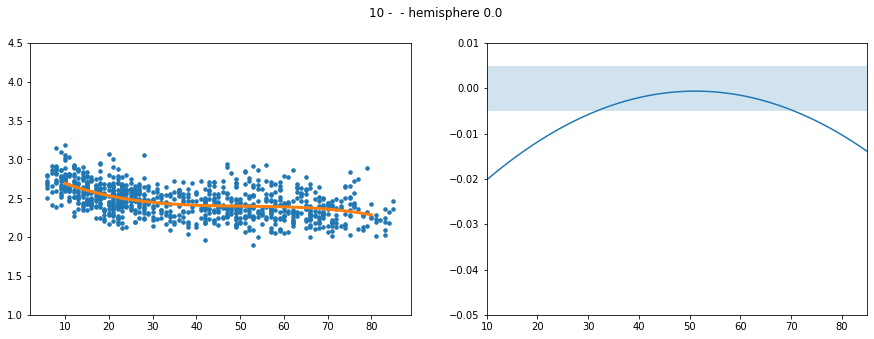

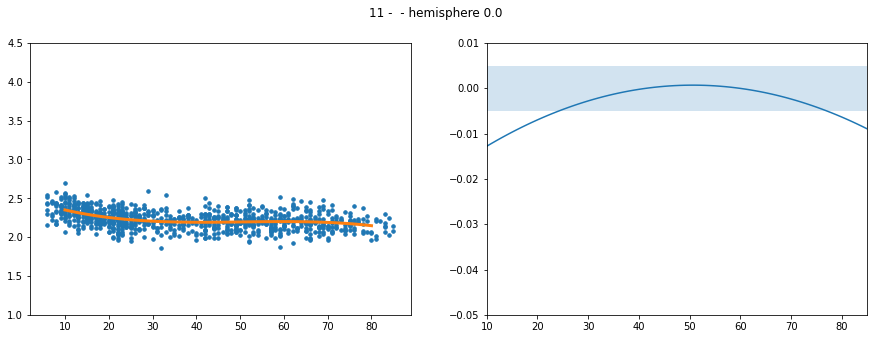

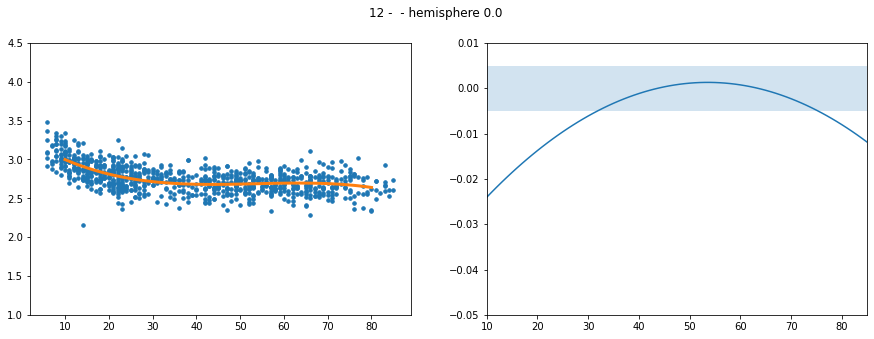

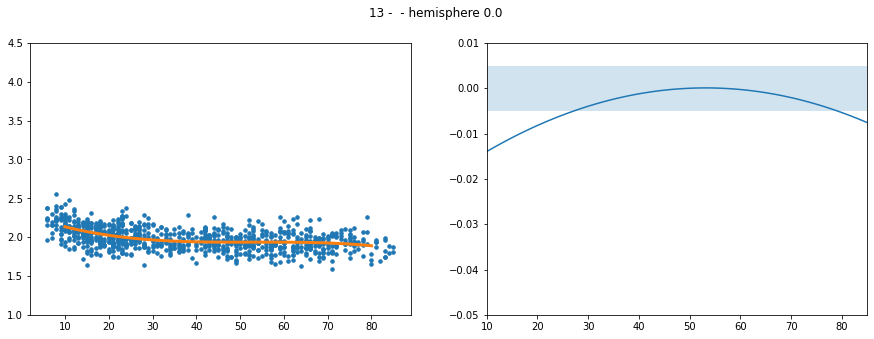

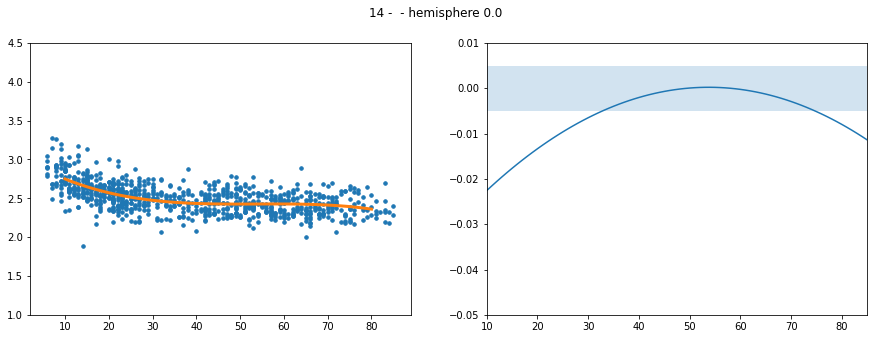

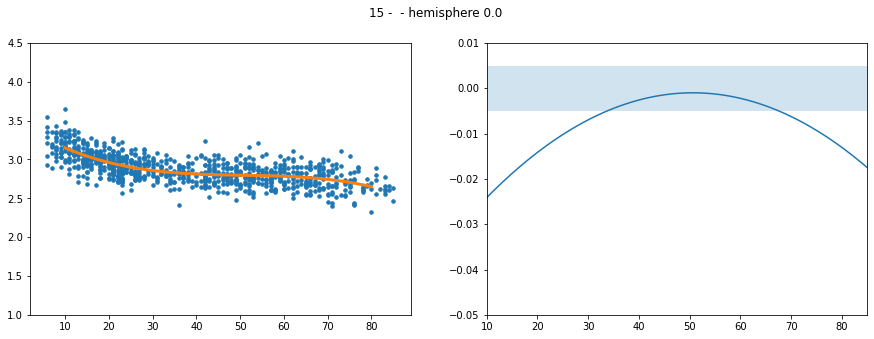

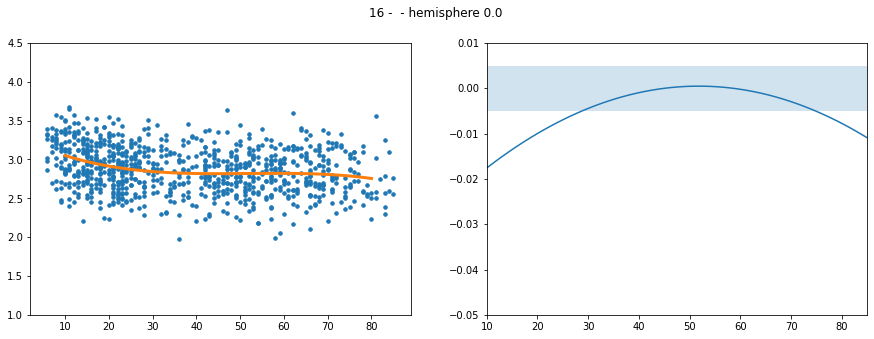

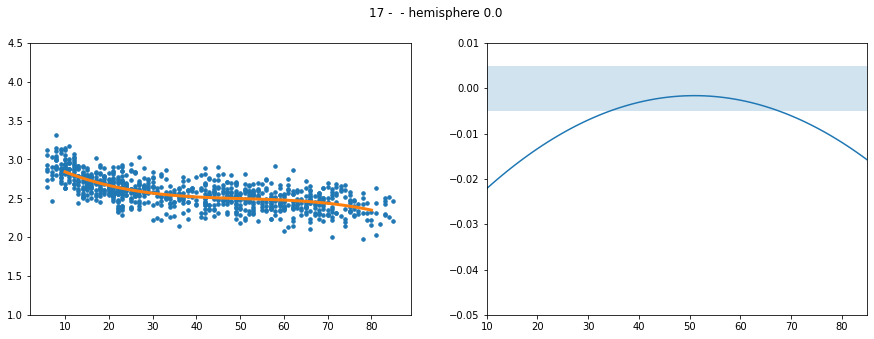

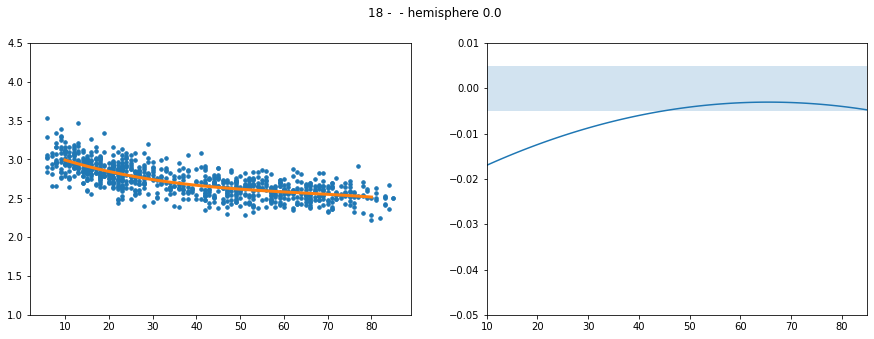

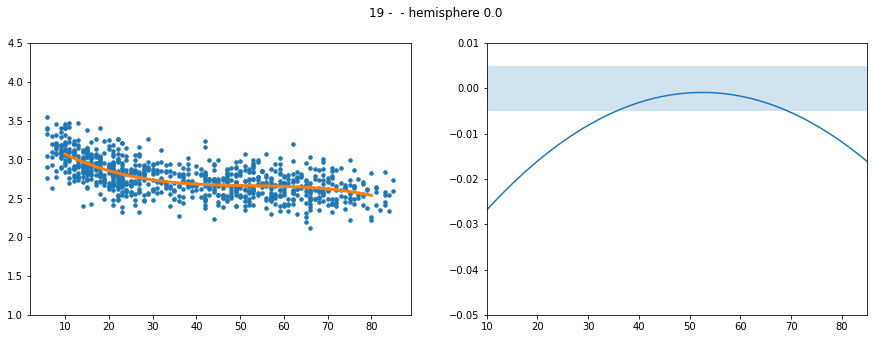

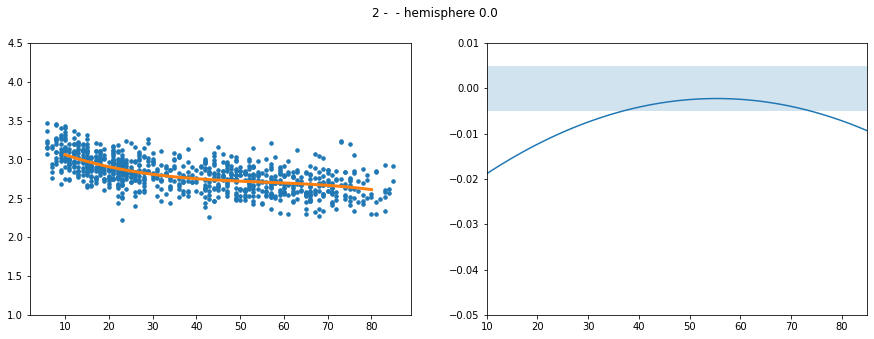

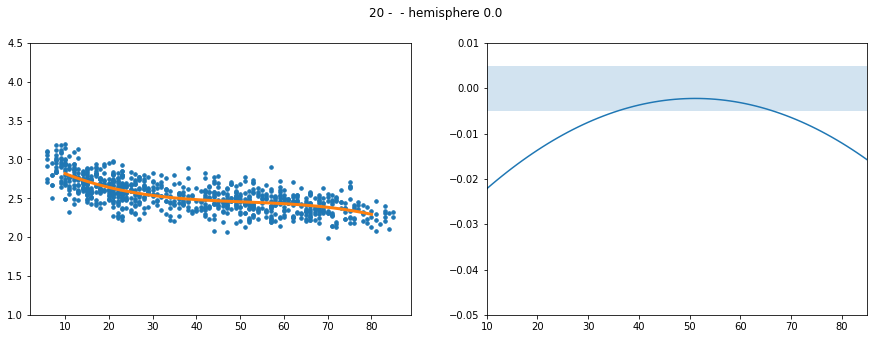

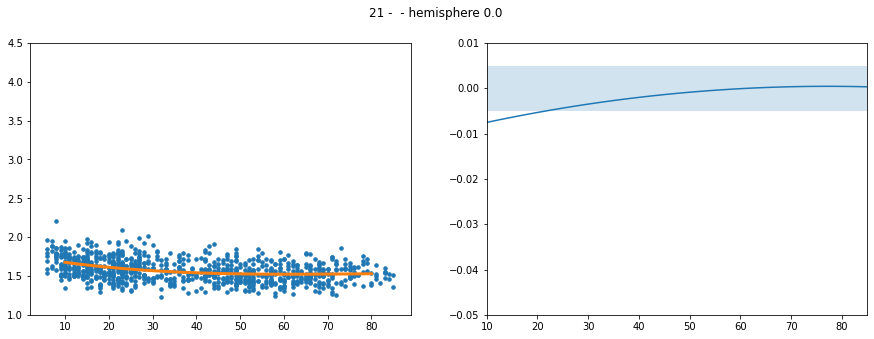

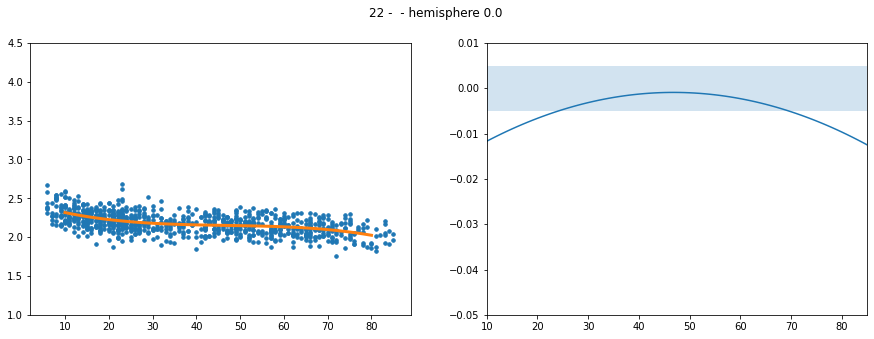

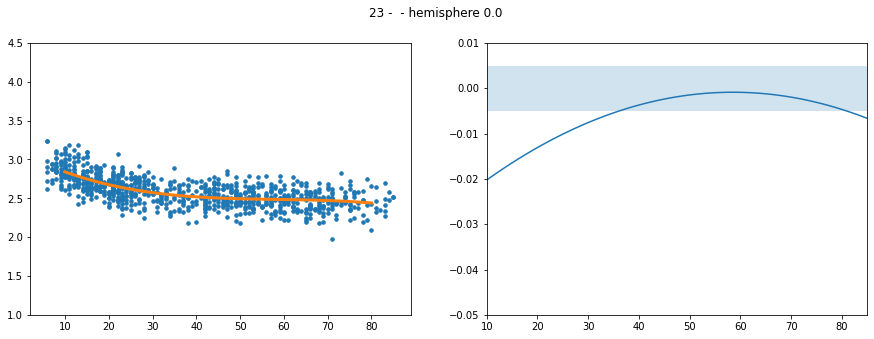

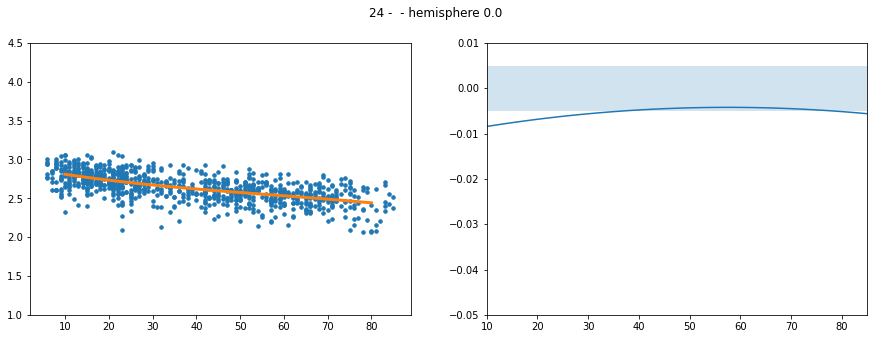

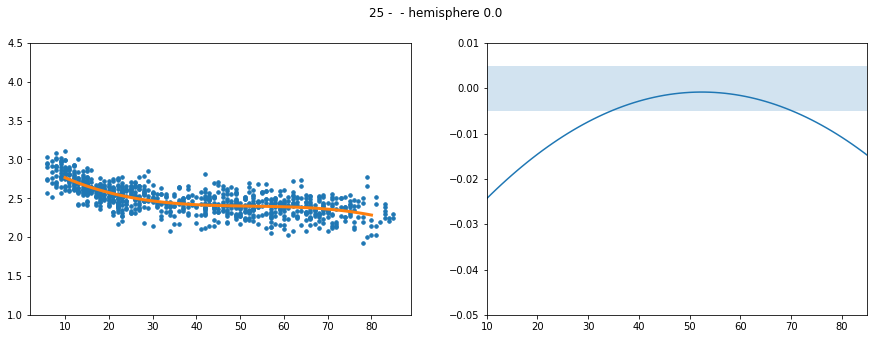

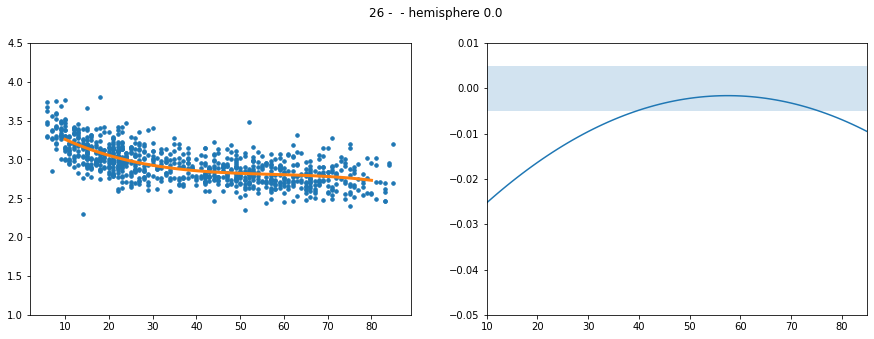

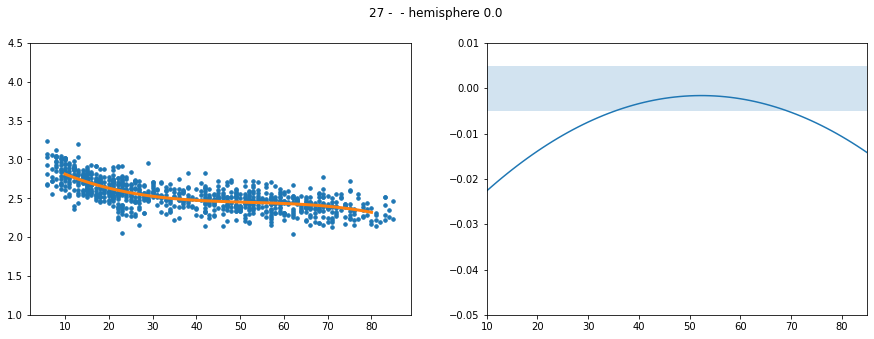

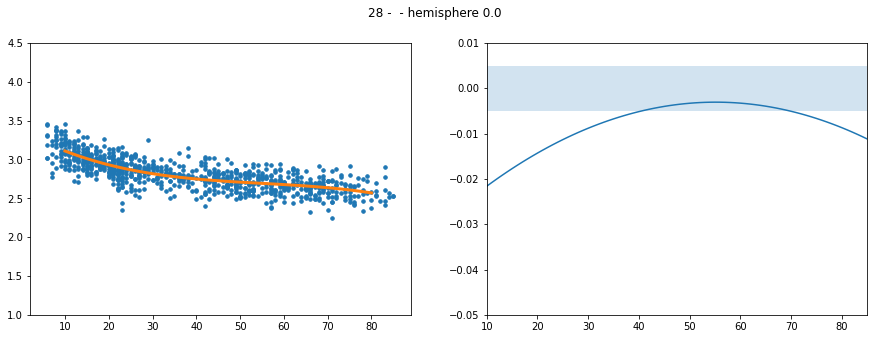

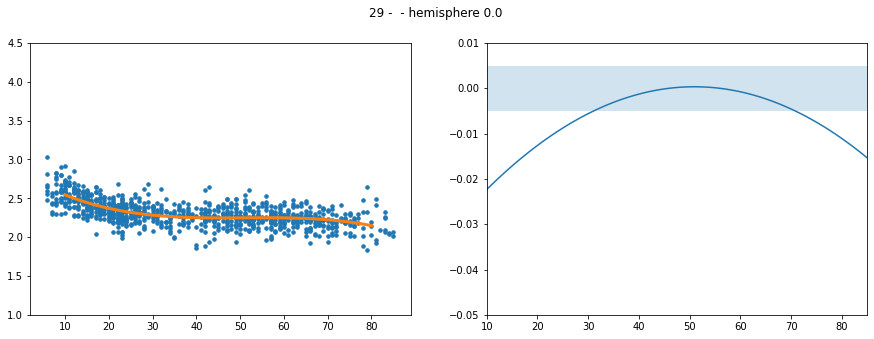

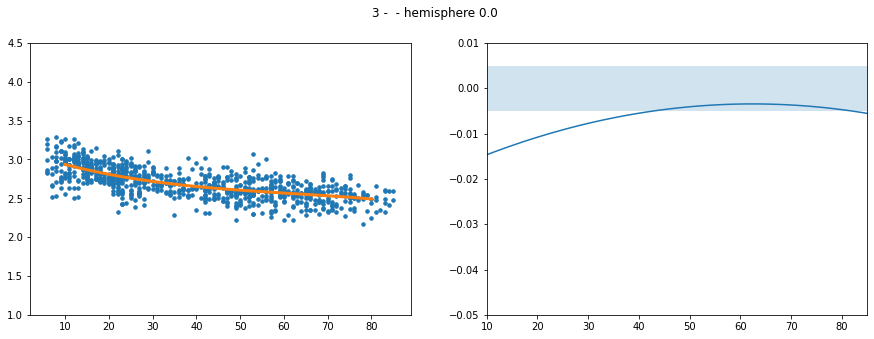

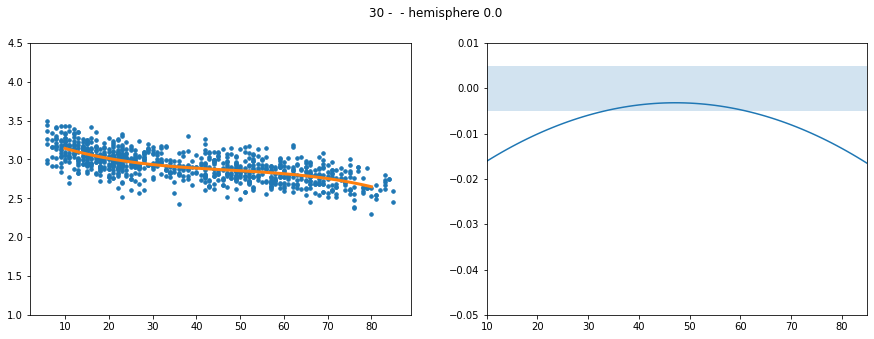

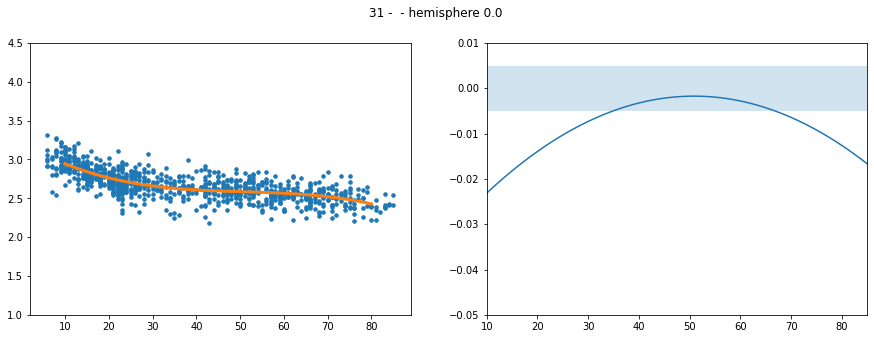

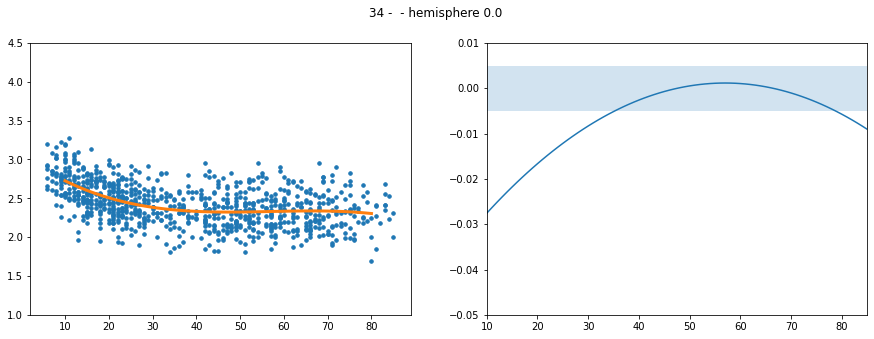

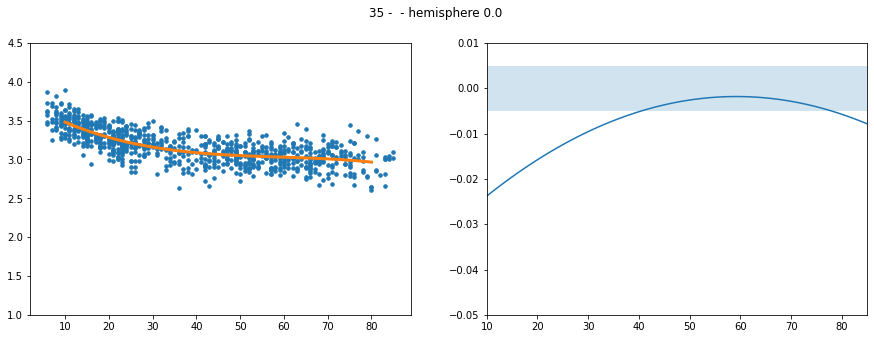

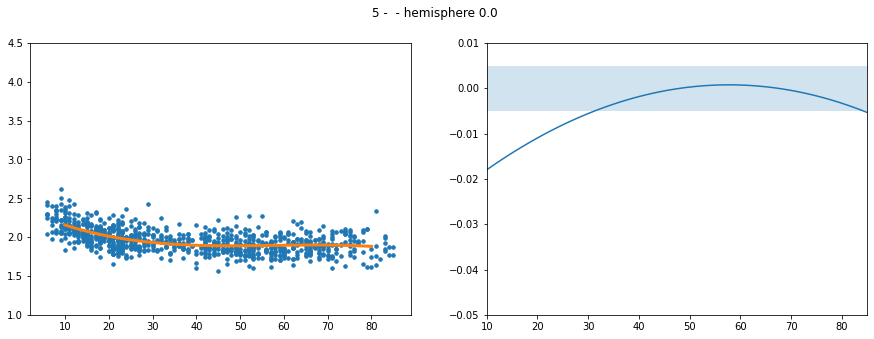

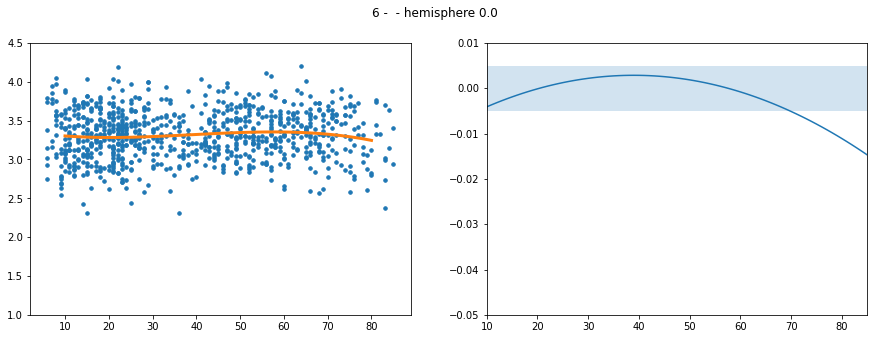

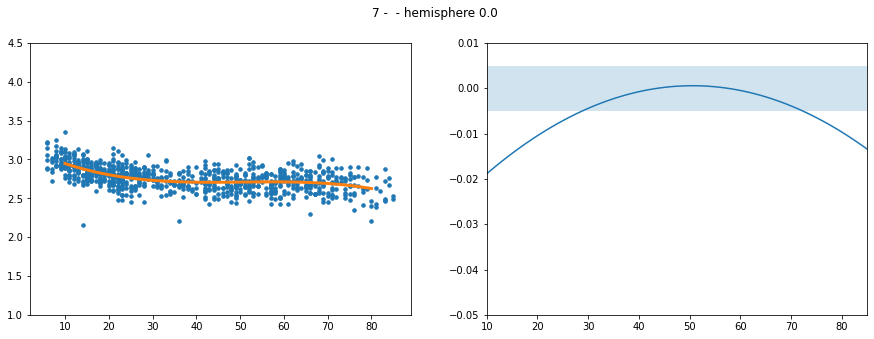

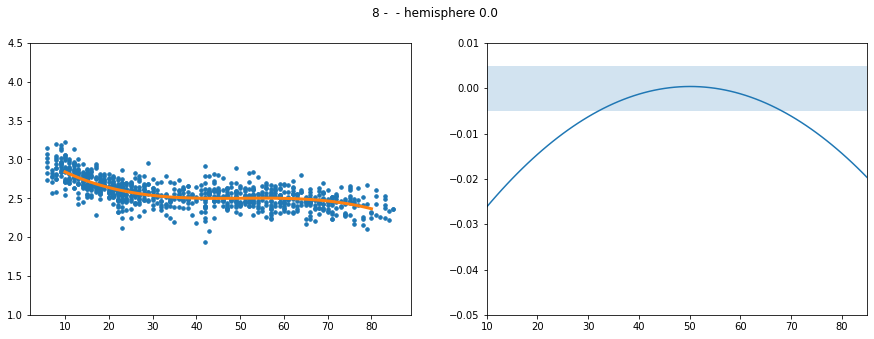

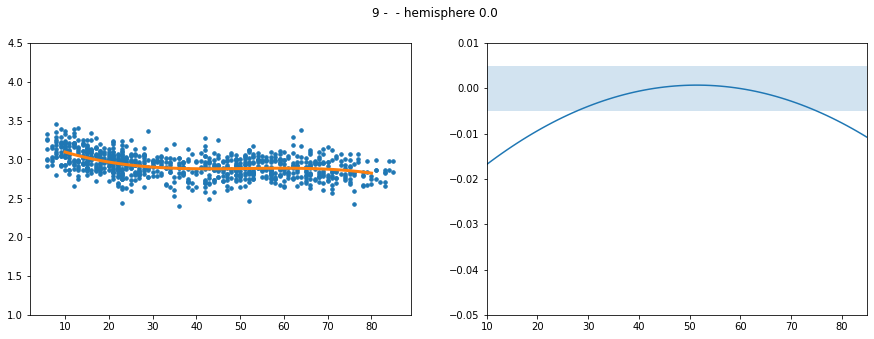

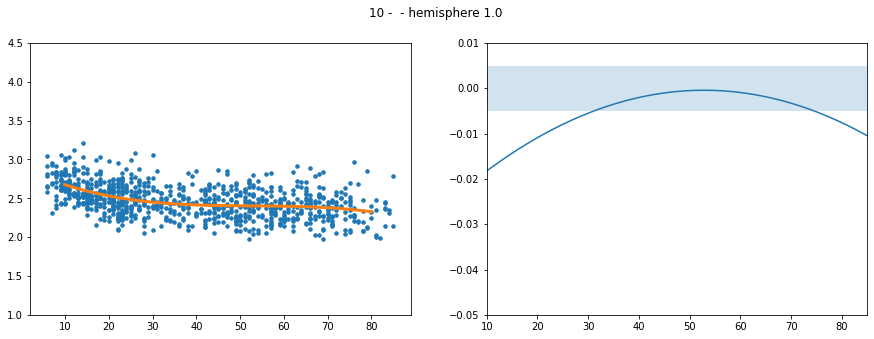

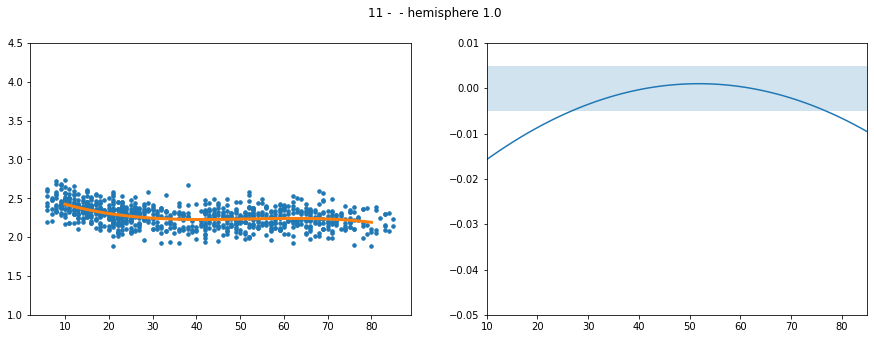

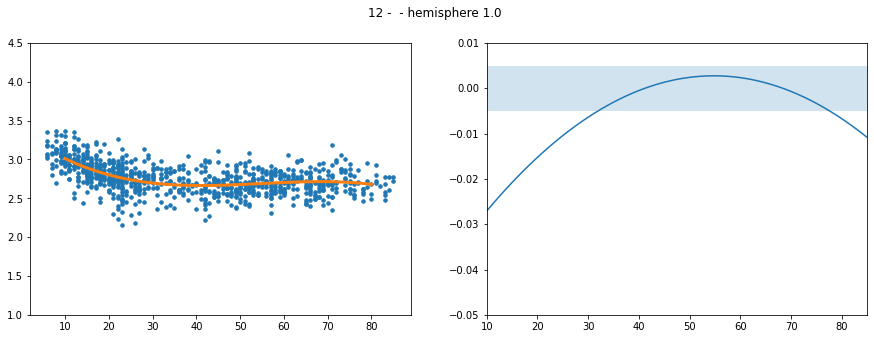

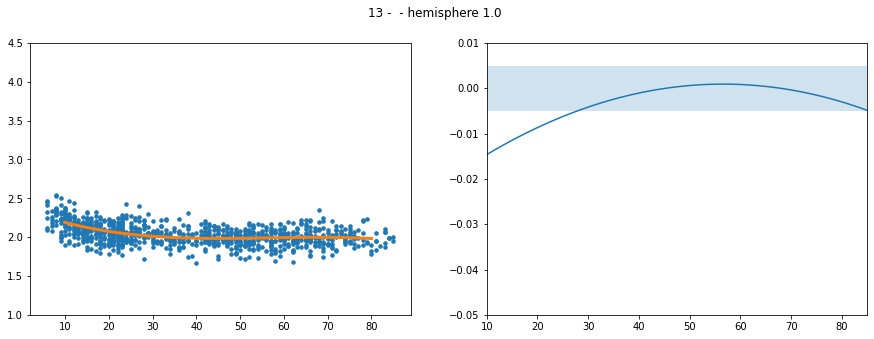

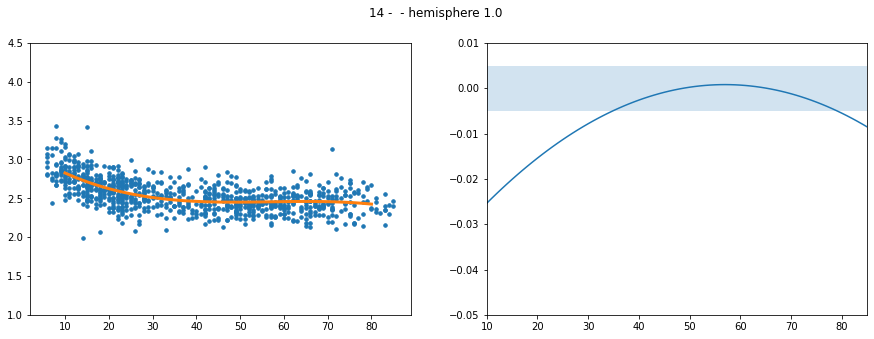

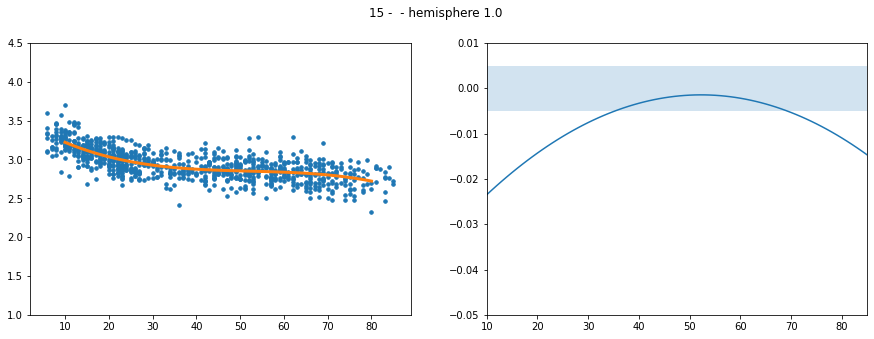

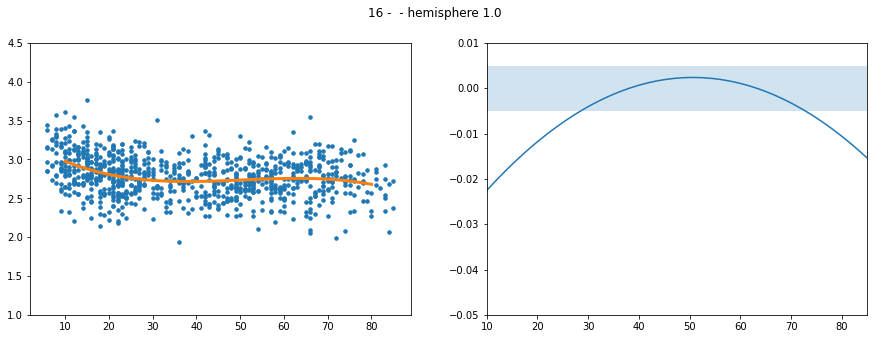

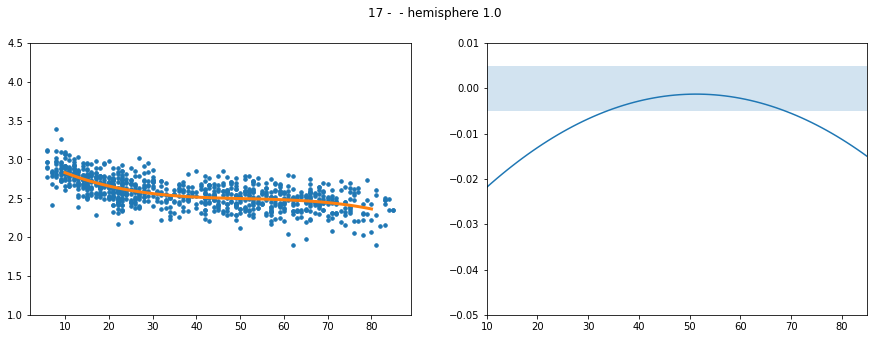

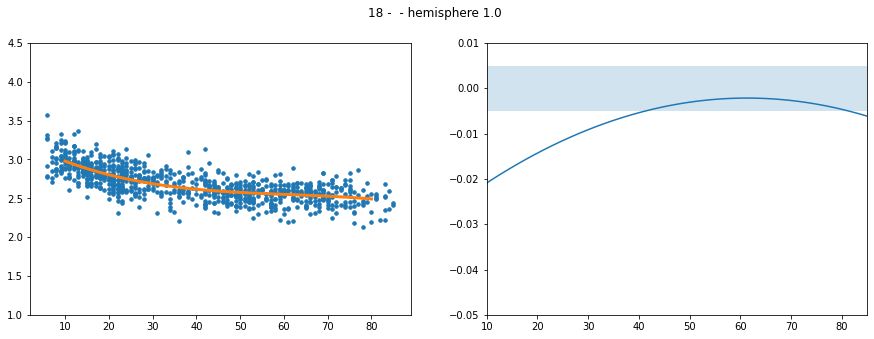

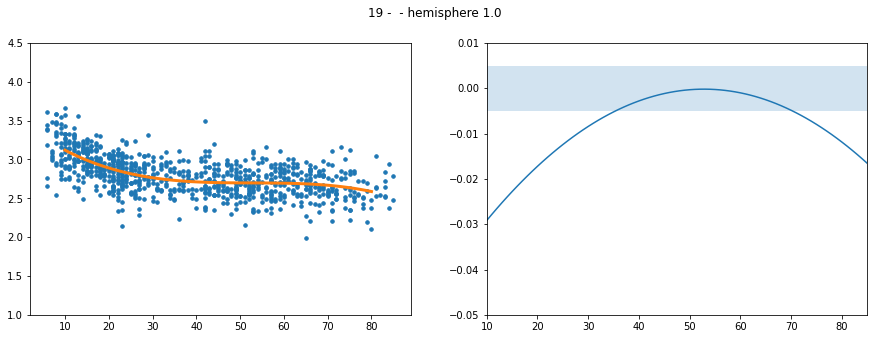

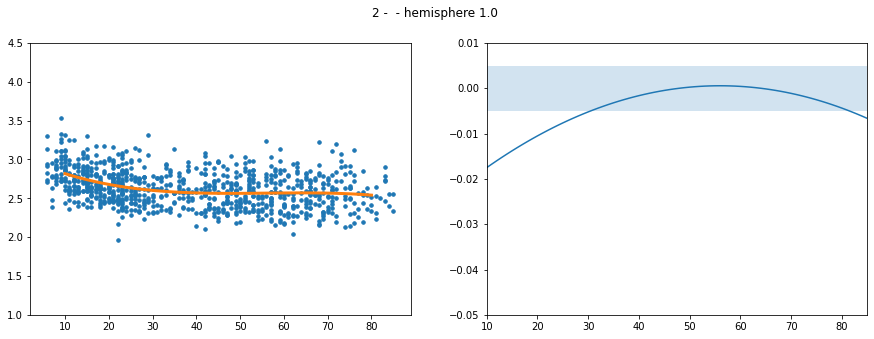

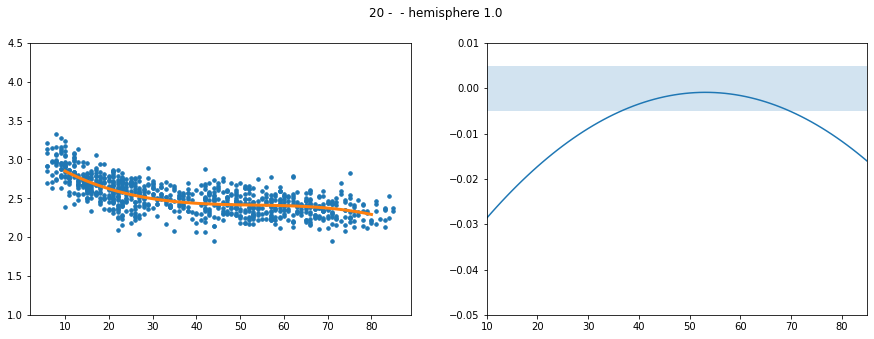

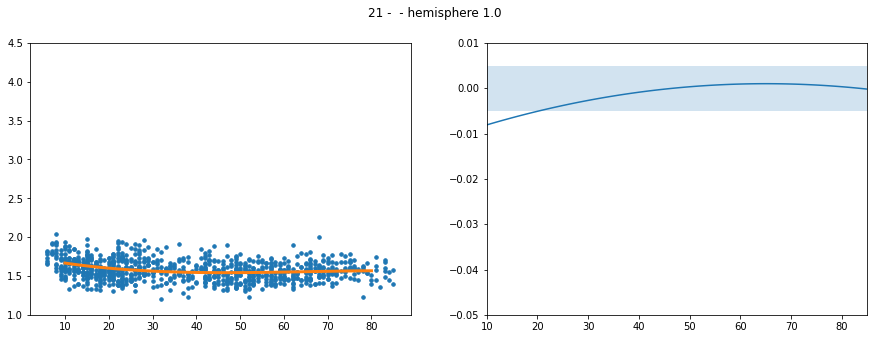

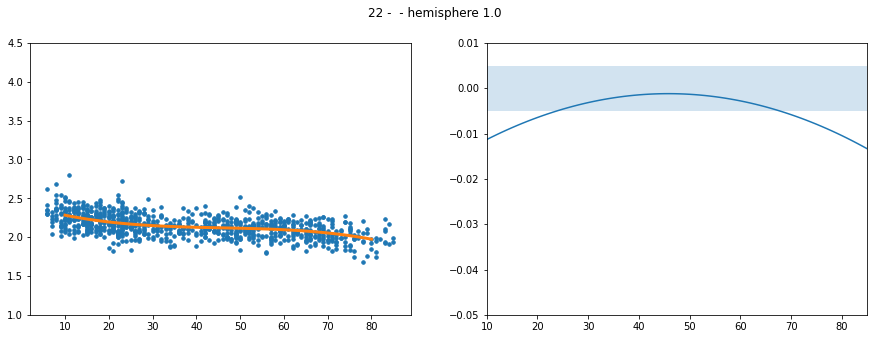

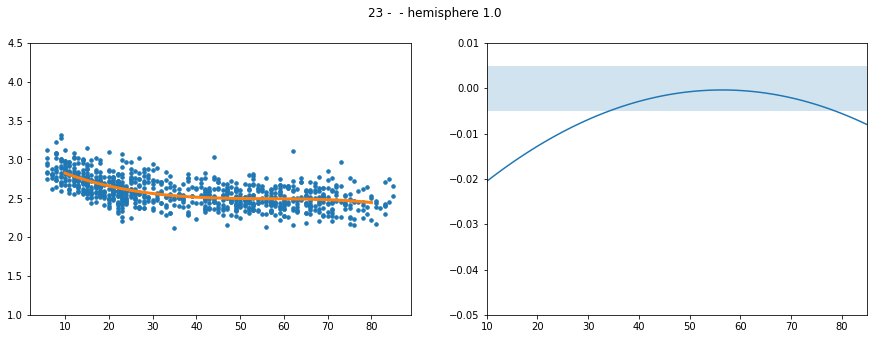

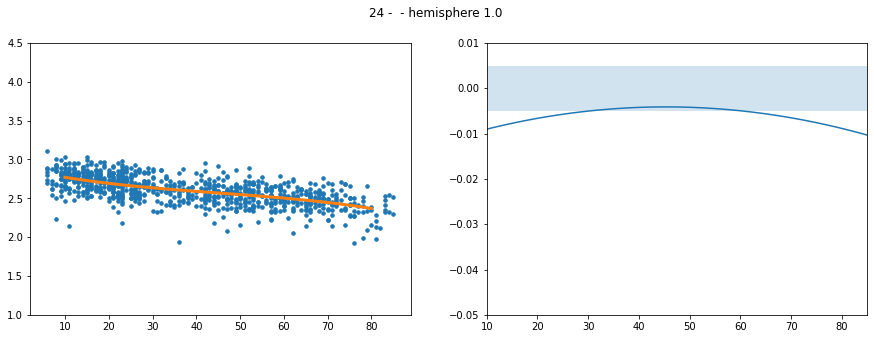

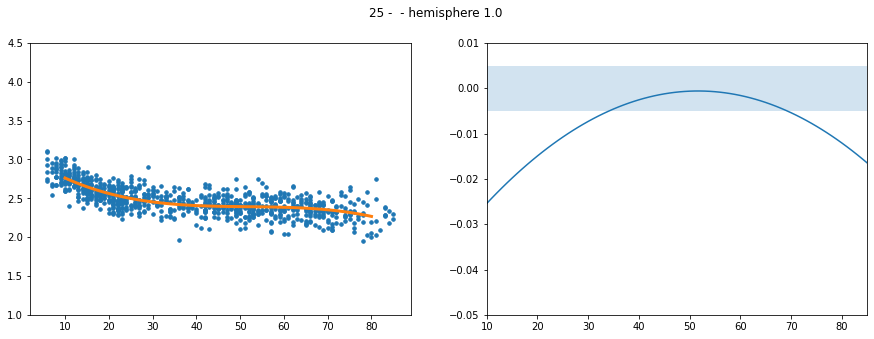

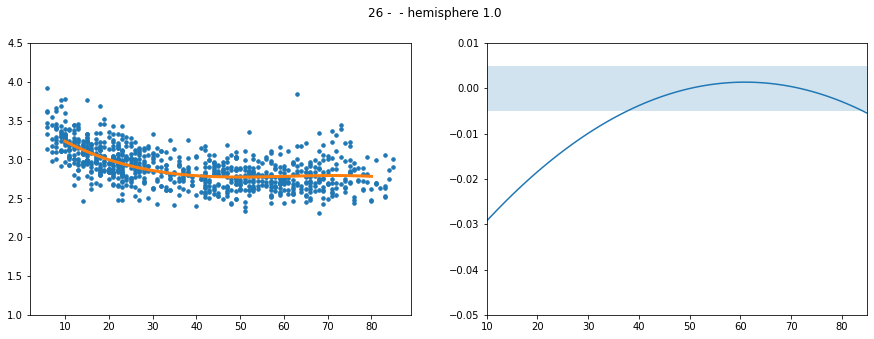

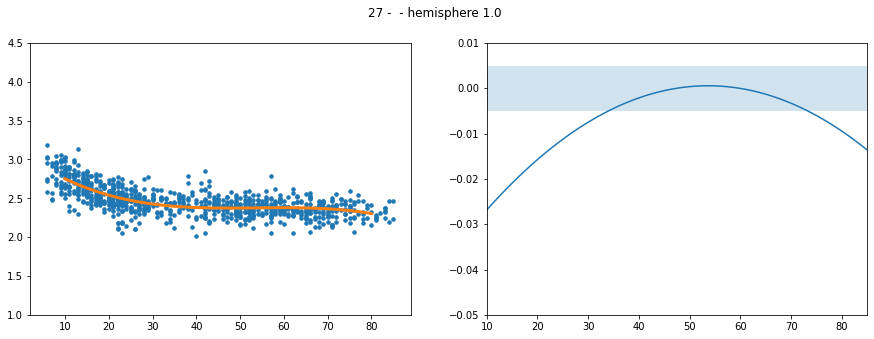

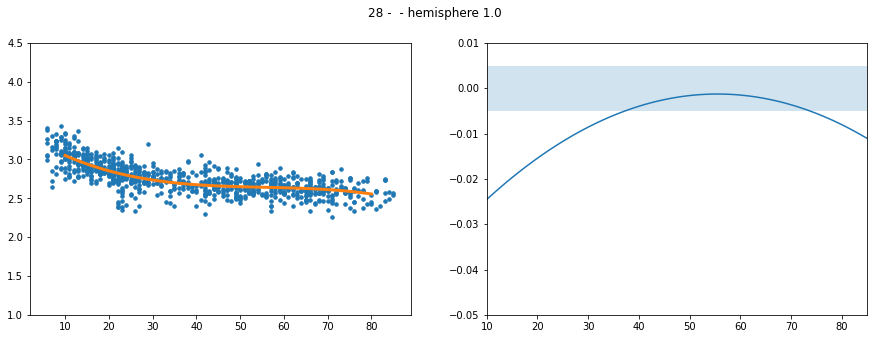

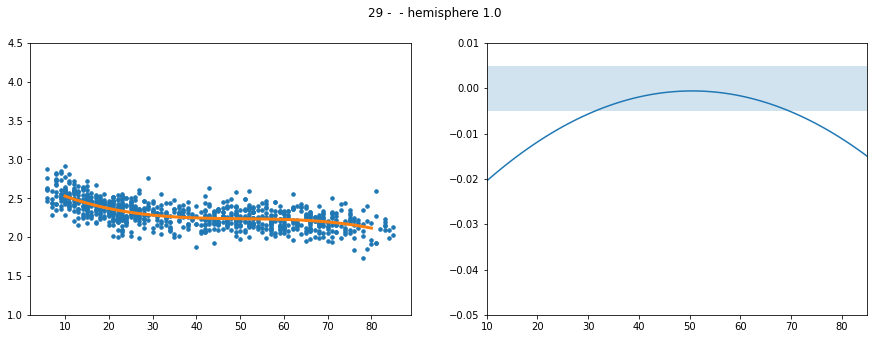

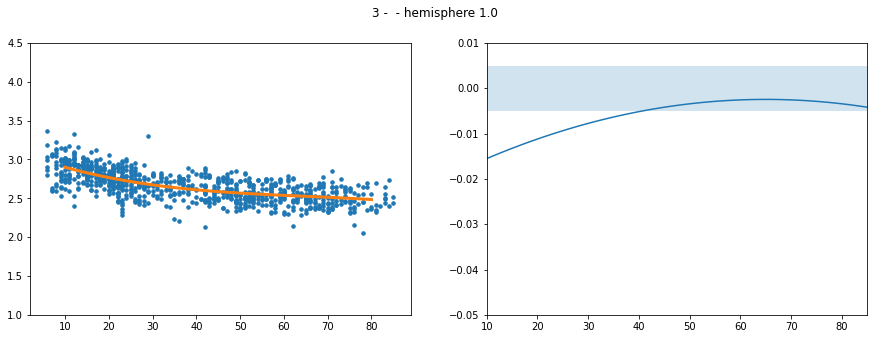

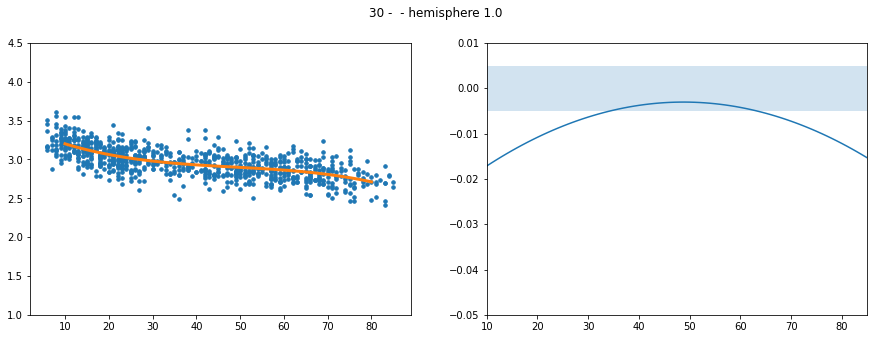

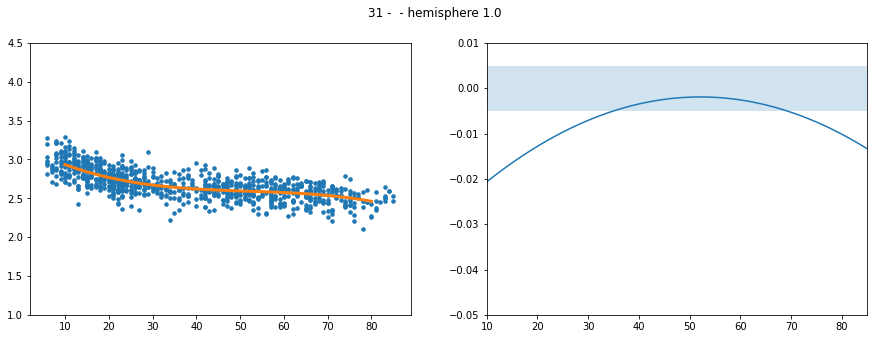

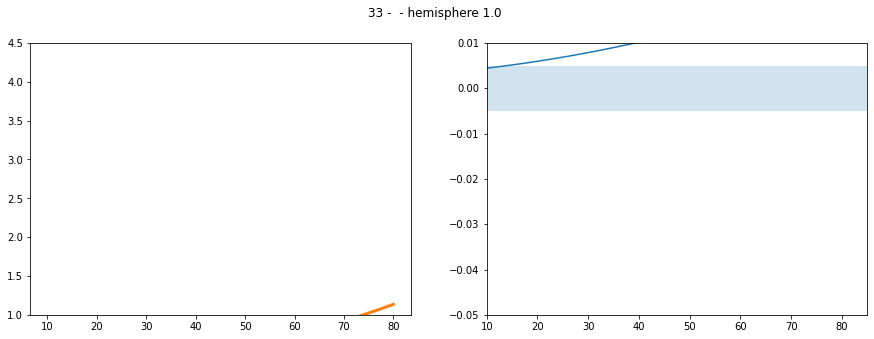

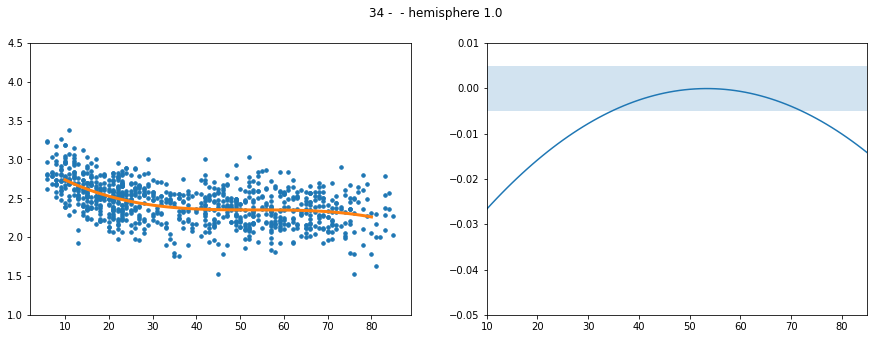

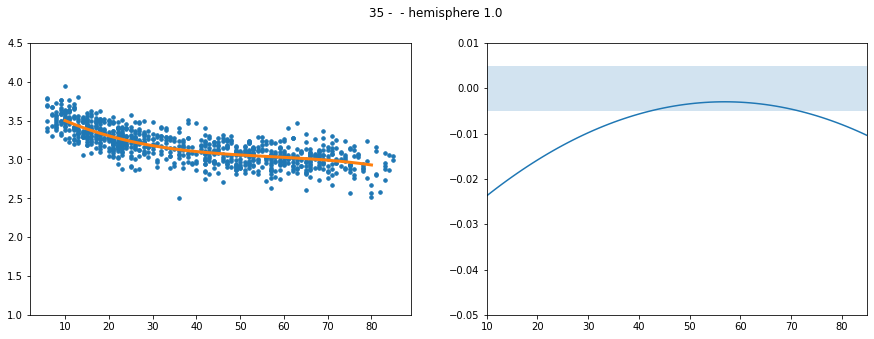

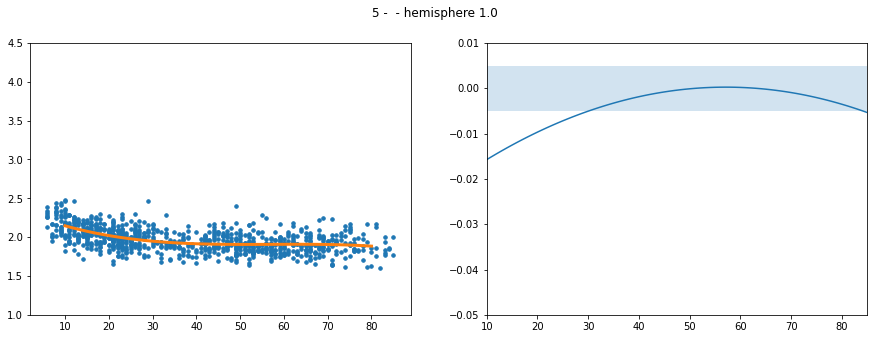

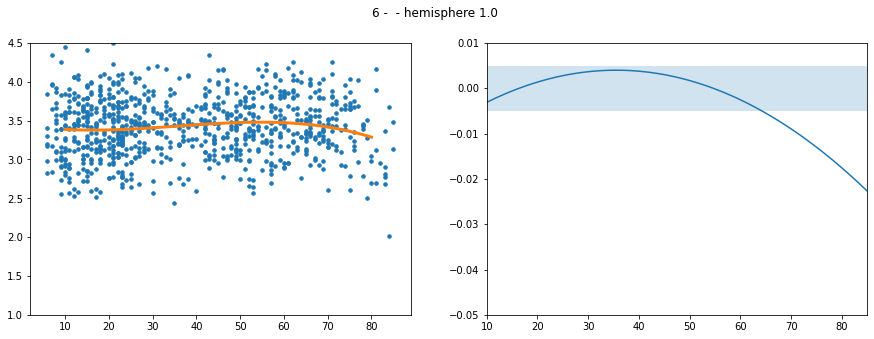

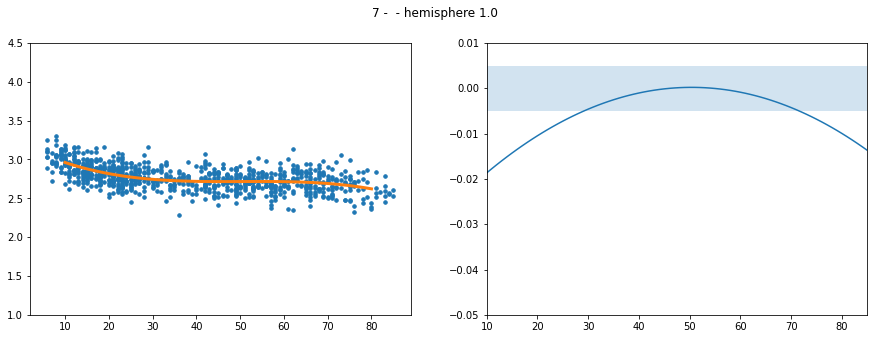

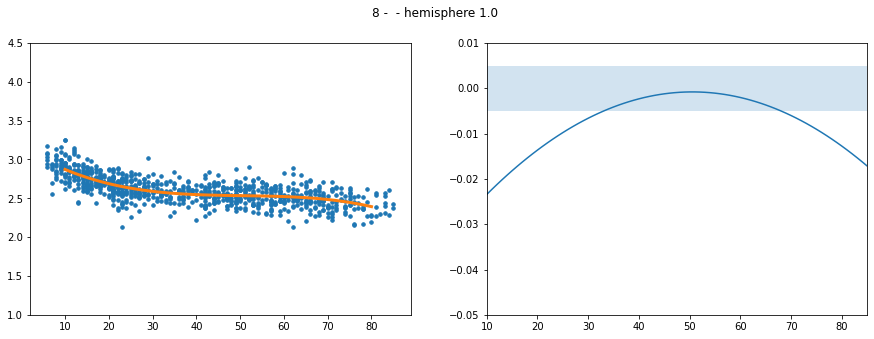

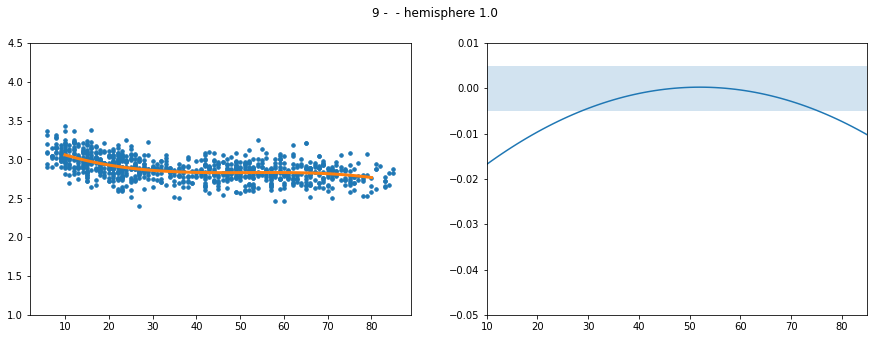

In [15]:
# ordenacao
h_structures = np.sort(df.h_structure.unique())


taxa_anual =[]
for h_structure in tqdm(h_structures):
    
    # variacao da espessura
    age = df[df.h_structure == h_structure].age
    thickness = df[df.h_structure == h_structure].thickness
    z = np.polyfit(age, thickness, 3)
    p = np.poly1d(z)
    xp = np.linspace(10, 80, 100)
    
    # variacao da variacao da espessura
    p2 = np.polyder(p)
    derivada = []
    for year in range(0, 100):
        derivada.append(p2(year))
    taxa_anual.append([h_structure]+ derivada)
    
    # plots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,5))
    a = h_structure[1:]
    b = ' - '#+df[df.h_structure == h_structure].name.iloc[0] 
    c = ' - hemisphere '+ str(df[df.h_structure == h_structure].hemisphere.iloc[0])
    fig.suptitle(a+b+c)
    _ = ax1.plot(age, thickness, '.', xp, p(xp), '-', linewidth=3, markersize=7)
    ax1.axis(ymin=1,ymax=4.5)
    ax2.plot(derivada)
    ax2.axis(ymin=-0.05,ymax=0.01)
    ax2.axis(xmin=10,xmax=85)
    ax2.fill_between([10,85], 0.005, -0.005, alpha=.2)
    
taxa_anual = pd.DataFrame(taxa_anual)
taxa_anual = taxa_anual.rename(columns={0: "atlasDKT"})
taxa_anual.set_index('atlasDKT', inplace=True)

In [16]:
taxa_anual

1         2         3         4         5         6  \
atlasDKT                                                               
010      -0.030900 -0.029727 -0.028577 -0.027450 -0.026347 -0.025267   
011      -0.020242 -0.019423 -0.018621 -0.017834 -0.017064 -0.016311   
012      -0.037021 -0.035603 -0.034212 -0.032848 -0.031510 -0.030199   
013      -0.021226 -0.020432 -0.019652 -0.018888 -0.018139 -0.017404   
014      -0.034183 -0.032914 -0.031670 -0.030449 -0.029253 -0.028080   
015      -0.036905 -0.035501 -0.034125 -0.032778 -0.031458 -0.030166   
016      -0.027269 -0.026208 -0.025167 -0.024148 -0.023149 -0.022171   
017      -0.033362 -0.032128 -0.030919 -0.029734 -0.028573 -0.027437   
018      -0.022459 -0.021871 -0.021293 -0.020723 -0.020162 -0.019611   
019      -0.040539 -0.039042 -0.037574 -0.036135 -0.034725 -0.033343   
02       -0.026975 -0.026089 -0.025220 -0.024367 -0.023530 -0.022710   
020      -0.033054 -0.031860 -0.030690 -0.029543 -0.028420 -0.027320   
021      -0.010077 -0.009807 -0.009539 -0.009276 -0.009015 -0.008759   
022      -0.018332 -0.017596 -0.016875 -0.016171 -0.015482 -0.014809   
023      -0.029042 -0.028088 -0.027150 -0.026228 -0.025323 -0.024435   
024      -0.010387 -0.010174 -0.009965 -0.009759 -0.009557 -0.009359   
025      -0.036746 -0.035387 -0.034055 -0.032749 -0.031469 -0.030216   
026      -0.036277 -0.035082 -0.033908 -0.032755 -0.031623 -0.030512   
027      -0.033770 -0.032551 -0.031356 -0.030184 -0.029036 -0.027912   
028      -0.030742 -0.029746 -0.028770 -0.027811 -0.026870 -0.025948   
029      -0.034771 -0.033406 -0.032068 -0.030757 -0.029474 -0.028217   
03       -0.019358 -0.018852 -0.018354 -0.017865 -0.017384 -0.016911   
030      -0.023967 -0.023095 -0.022242 -0.021408 -0.020592 -0.019796   
031      -0.034892 -0.033601 -0.032335 -0.031096 -0.029881 -0.028693   
034      -0.041106 -0.039636 -0.038192 -0.036773 -0.035381 -0.034015   
035      -0.033628 -0.032562 -0.031515 -0.030486 -0.029475 -0.028482   
05       -0.026667 -0.025725 -0.024800 -0.023891 -0.022999 -0.022123   
06       -0.009726 -0.009088 -0.008467 -0.007862 -0.007273 -0.006701   
07       -0.029625 -0.028442 -0.027283 -0.026148 -0.025036 -0.023948   
08       -0.041091 -0.039452 -0.037845 -0.036272 -0.034732 -0.033225   
09       -0.026281 -0.025241 -0.024222 -0.023223 -0.022244 -0.021286   
110      -0.027530 -0.026514 -0.025517 -0.024540 -0.023582 -0.022644   
111      -0.024701 -0.023717 -0.022752 -0.021807 -0.020881 -0.019973   
112      -0.041895 -0.040279 -0.038693 -0.037137 -0.035611 -0.034114   
113      -0.022026 -0.021222 -0.020433 -0.019657 -0.018896 -0.018150   
114      -0.037717 -0.036376 -0.035058 -0.033765 -0.032495 -0.031248   
115      -0.035163 -0.033885 -0.032631 -0.031402 -0.030198 -0.029019   
116      -0.036334 -0.034820 -0.033336 -0.031883 -0.030460 -0.029067   
117      -0.033022 -0.031796 -0.030594 -0.029416 -0.028262 -0.027132   
118      -0.028910 -0.028044 -0.027193 -0.026355 -0.025532 -0.024724   
119      -0.044290 -0.042636 -0.041013 -0.039423 -0.037863 -0.036336   
12       -0.026221 -0.025273 -0.024342 -0.023428 -0.022531 -0.021651   
120      -0.043028 -0.041456 -0.039915 -0.038403 -0.036920 -0.035468   
121      -0.011685 -0.011297 -0.010916 -0.010540 -0.010171 -0.009807   
122      -0.017765 -0.017049 -0.016348 -0.015663 -0.014994 -0.014341   
123      -0.030160 -0.029113 -0.028085 -0.027075 -0.026084 -0.025112   
124      -0.012197 -0.011843 -0.011498 -0.011160 -0.010831 -0.010509   
125      -0.038765 -0.037301 -0.035867 -0.034460 -0.033083 -0.031734   
126      -0.042481 -0.041053 -0.039649 -0.038269 -0.036912 -0.035579   
127      -0.040864 -0.039333 -0.037832 -0.036359 -0.034915 -0.033500   
128      -0.035899 -0.034661 -0.033446 -0.032254 -0.031084 -0.029937   
129      -0.031465 -0.030254 -0.029067 -0.027904 -0.026766 -0.025652   
13       -0.020694 -0.020137 -0.019589 -0.019049 -0.018518 -0.017996   
130      -0.025358 -0.024453 -0.023566 -0.022698 -0.02184

-------------------

## 2. Modelagem para prever variação de espessura anual

#### 2.1. DataSet

In [17]:
def rate(h_structure, age):
    return taxa_anual.loc[h_structure, age]

# add anual rate
df1 = df.copy()
df1['anual_rate'] = df1.apply(lambda x: rate(x.h_structure, x.age), axis=1)

# add initial thickness (at 10 years)
thickness10 = df1[df1.age == 10][['h_structure', 'thickness']].groupby(['h_structure']).mean()
thickness10 = thickness10.rename(columns={'thickness':'thickness10'})
df1 = df1.merge(thickness10, on='h_structure')

# uni os dados de cada idade
dfs = []
for h_structure in df.h_structure.unique():
    df0 = df1[df1.h_structure == h_structure].groupby(['age']).mean()
    df0['h_structure'] = h_structure
    dfs.append(df0.reset_index())

# show
df1 = pd.concat(dfs).reset_index(drop=True)
df1

age       sex  handedness  hemisphere  atlasDF      area      curv  \
0      6.0  0.714286    1.857143         0.0     10.0  0.655077 -0.027693   
1      7.0  0.000000    1.666667         0.0     10.0  0.646284 -0.028095   
2      8.0  0.333333    1.666667         0.0     10.0  0.652489 -0.024335   
3      9.0  0.357143    1.642857         0.0     10.0  0.647904 -0.021873   
4     10.0  0.500000    1.833333         0.0     10.0  0.645049 -0.019936   
5     11.0  0.600000    1.666667         0.0     10.0  0.643423 -0.023700   
6     12.0  0.647059    1.882353         0.0     10.0  0.639945 -0.024104   
7     13.0  0.500000    1.812500         0.0     10.0  0.641851 -0.023911   
8     14.0  0.437500    1.937500         0.0     10.0  0.645166 -0.014850   
9     15.0  0.555556    1.925926         0.0     10.0  0.640563 -0.016640   
10    16.0  0.625000    1.812500         0.0     10.0  0.638568 -0.018911   
11    17.0  0.466667    1.733333         0.0     10.0  0.640958 -0.013291   
12    18.0  0.619048    1.904762         0.0     10.0  0.642860 -0.016959   
13    19.0  0.454545    1.818182         0.0     10.0  0.639652 -0.015259   
14    20.0  0.400000    1.933333         0.0     10.0  0.638102 -0.016359   
15    21.0  0.379310    1.827586         0.0     10.0  0.641413 -0.010680   
16    22.0  0.500000    1.961538         0.0     10.0  0.641705 -0.015749   
17    23.0  0.571429    1.928571         0.0     10.0  0.646749 -0.014167   
18    24.0  0.461538    1.846154         0.0     10.0  0.645115 -0.021647   
19    25.0  0.333333    1.800000         0.0     10.0  0.639032 -0.008956   
20    26.0  0.428571    2.000000         0.0     10.0  0.642309 -0.010975   
21    27.0  0.500000    1.928571         0.0     10.0  0.645794 -0.015599   
22    28.0  0.538462    1.538462         0.0     10.0  0.630486 -0.010984   
23    29.0  0.500000    1.750000         0.0     10.0  0.642201  0.002308   
24    30.0  0.500000    1.900000         0.0     10.0  0.638553 -0.020544   
25    31.0  0.333333    2.000000         0.0     10.0  0.648962 -0.009619   
26    32.0  0.500000    1.750000         0.0     10.0  0.640637 -0.004476   
27    33.0  0.500000    1.750000         0.0     10.0  0.646298 -0.015997   
28    34.0  0.250000    2.000000         0.0     10.0  0.636098 -0.008750   
29    35.0  0.333333    2.333333         0.0     10.0  0.653639 -0.004196   
30    36.0  0.444444    1.777778         0.0     10.0  0.636623 -0.011315   
31    37.0  0.333333    1.777778         0.0     10.0  0.638191 -0.007865   
32    38.0  0.444444    2.000000         0.0     10.0  0.646226 -0.019551   
33    39.0  0.000000    2.000000         0.0     10.0  0.646350 -0.001609   
34    40.0  0.400000    1.600000         0.0     10.0  0.634402 -0.010436   
35    41.0  0.400000    2.000000         0.0     10.0  0.641571 -0.015498   
36    42.0  0.294118    1.882353         0.0     10.0  0.647410 -0.012065   
37    43.0  0.200000    1.900000         0.0     10.0  0.643949 -0.009213   
38    44.0  0.285714    2.000000         0.0     10.0  0.642472 -0.007752   
39    45.0  0.300000    1.800000         0.0     10.0  0.639266 -0.009247   
40    46.0  0.222222    1.888889         0.0     10.0  0.642626 -0.005252   
41    47.0  0.153846    2.000000         0.0     10.0  0.642101 -0.007003   
42    48.0  0.250000    2.000000         0.0     10.0  0.646898 -0.005982   
43    49.0  0.200000    1.900000         0.0     10.0  0.636462 -0.004695   
44    50.0  0.300000    1.800000         0.0     10.0  0.637777 -0.013327   
45    51.0  0.250000    1.666667         0.0     10.0  0.634456 -0.008674   
46    52.0  0.000000    1.857143         0.0     10.0  0.636997 -0.002119   
47    53.0  0.125000    1.937500         0.0     10.0  0.637550 -0.008241   
48    54.0  0.111111    1.888889         0.0     10.0  0.632122  0.002616   
49    55.0  0.333333    1.500000         0.0     10.0  0.641071 -0.012153   
50    56.0  0.000000    1.555556         0.0     10.0  0.639100 -0.005242   
51 

In [18]:
df1.columns

Index(['age', 'sex', 'handedness', 'hemisphere', 'atlasDF', 'area', 'curv',
       'sulc', 'thickness', 'bigbrain_layer_1', 'bigbrain_layer_2',
       'bigbrain_layer_3', 'bigbrain_layer_4', 'bigbrain_layer_5',
       'bigbrain_layer_6', 'anual_rate', 'thickness10', 'h_structure'],
      dtype='object')

In [19]:
df1['thickness_layer_1'] = df1.thickness * df1.bigbrain_layer_1
df1['thickness_layer_2'] = df1.thickness * df1.bigbrain_layer_2
df1['thickness_layer_3'] = df1.thickness * df1.bigbrain_layer_3
df1['thickness_layer_4'] = df1.thickness * df1.bigbrain_layer_4
df1['thickness_layer_5'] = df1.thickness * df1.bigbrain_layer_5
df1['thickness_layer_6'] = df1.thickness * df1.bigbrain_layer_6
df1['sum_thickness_layers'] = df1['thickness_layer_1']+ df1['thickness_layer_2']+df1['thickness_layer_3']+df1['thickness_layer_4']+df1['thickness_layer_5']+df1['thickness_layer_6']
df1[['sum_thickness_layers', 'thickness']]

sum_thickness_layers  thickness
0                 2.688395   2.688395
1                 2.710835   2.710835
2                 2.791334   2.791334
3                 2.704111   2.704111
4                 2.794945   2.794945
5                 2.671345   2.671345
6                 2.679617   2.679617
7                 2.614984   2.614984
8                 2.619863   2.619863
9                 2.589860   2.589860
10                2.536180   2.536180
11                2.543308   2.543308
12                2.585431   2.585431
13                2.426585   2.426586
14                2.526041   2.526041
15                2.533312   2.533312
16                2.476022   2.476022
17                2.507186   2.507186
18                2.523872   2.523872
19                2.528819   2.528819
20                2.455618   2.455618
21                2.499052   2.499052
22                2.490320   2.490320
23                2.484931   2.484931
24                2.372337   2.372337
25                2.508247   2.508247
26                2.412205   2.412205
27                2.406120   2.406120
28                2.337935   2.337935
29                2.404252   2.404252
30                2.488350   2.488350
31                2.426889   2.426889
32                2.335337   2.335337
33                2.473060   2.473060
34                2.381111   2.381111
35                2.434846   2.434846
36                2.355040   2.355040
37                2.489447   2.489447
38                2.437310   2.437310
39                2.379082   2.379082
40                2.446442   2.446442
41                2.451630   2.451630
42                2.450117   2.450117
43                2.395731   2.395731
44                2.345591   2.345591
45                2.428419   2.428419
46                2.399728   2.399728
47                2.403560   2.403560
48                2.473083   2.473083
49                2.343359   2.343359
50                2.503673   2.503673
51                2.375096   2.375096
52                2.354674   2.354674
53                2.391041   2.391041
54                2.351213   2.351213
55                2.399454   2.399454
56                2.317460   2.317460
57                2.493315   2.493315
58                2.510899   2.510899
59                2.425342   2.425342
60                2.301077   2.301077
61                2.322597   2.322597
62                2.320039   2.320039
63                2.337734   2.337734
64                2.323804   2.323804
65                2.229980   2.229980
66                2.293141   2.293141
67                2.342873   2.342873
68                2.363880   2.363880
69                2.431506   2.431506
70                2.491467   2.491467
71                2.405797   2.405797
72                2.212869   2.212869
73                2.451645   2.451645
74                2.312082   2.312082
75                2.181307   2.181307
76                2.222380   2.222380
77                2.184870   2.184870
78                2.257070   2.257070
79                2.411644   2.411644
80                2.389518   2.389518
81                2.357817   2.357817
82                2.363988   2.363988
83                2.371665   2.371665
84                2.383426   2.383426
85                2.347021   2.347021
86                2.362596   2.362596
87                2.273036   2.273036
88                2.313709   2.313709
89                2.305843   2.305843
90                2.297177   2.297177
91                2.256141   2.256141
92                2.259553   2.259553
93                2.252378   2.252378
94                2.223650   2.223650
95                2.252806   2.252806
96                2.205235   2.205235
97                2.238441   2.238441
98                2.220687   2.220687
99                2.167621   2.167621
100               2.255252   2.255252
101               2.219884   2.219884
102               2.245973   2.245973
103               2.293582   2.293582
104             

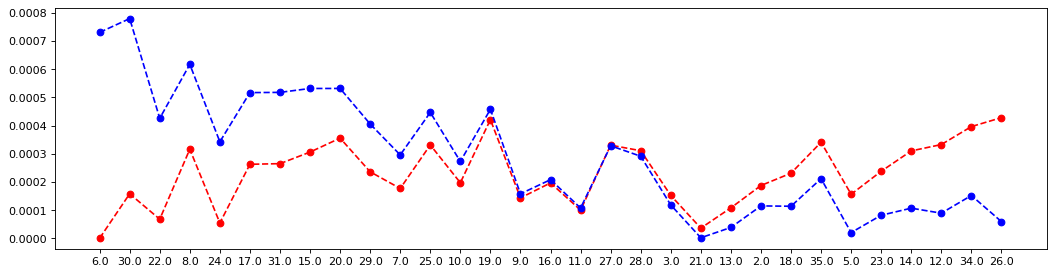

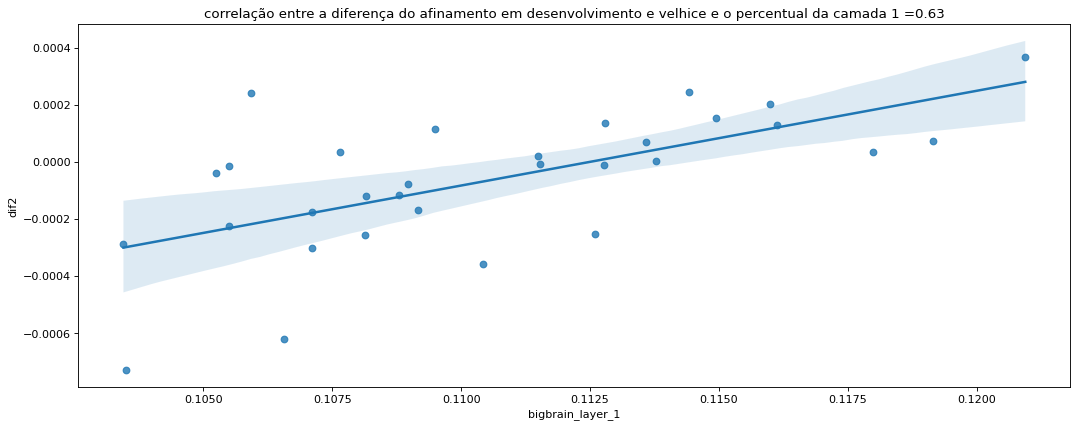

In [26]:
list_avg_rate = []

for i in df1.atlasDF.unique():
    
    df5 = df1[df1.atlasDF==i]
    avg_rate1 = df5[df1.age<=30].anual_rate.mean()
    avg_rate2 = df5[(df1.age<60) & (df1.age>30)].anual_rate.mean()
    avg_rate3 = df5[df1.age>=60].anual_rate.mean()
    
    l1 = df5.thickness_layer_1.mean()
    b1 = df5.bigbrain_layer_1.mean()
    t10 = df5.thickness10.mean()
    
    list_avg_rate.append([str(i),i,l1,b1,t10,avg_rate1,avg_rate2,avg_rate3])

df5 = pd.DataFrame(list_avg_rate)#.sort_values(by=2)
df5.columns = ['atlasDF_str','atlasDF_int',
               'thickness_layer_1', # resultados sofrem interferencia da espessura inicial
               'bigbrain_layer_1', 
               'thickness10', # resultados do trabalho do bruno
               'avg_rate1', 'avg_rate2', 'avg_rate3']

df5['dif'] = np.log(df5.avg_rate1 - df5.avg_rate3)
df5['dif1'] = df5.avg_rate1 - df5.avg_rate3
df5['dif2'] = df5.avg_rate1*df5.avg_rate1 - df5.avg_rate3*df5.avg_rate3*10
df5 = df5.sort_values(by = 'dif2')

plt.figure(figsize=(16, 4), dpi=80)
plt.plot(df5.atlasDF_str, df5.avg_rate1*df5.avg_rate1, '--ro')
plt.plot(df5.atlasDF_str, df5.avg_rate3*df5.avg_rate3*10, '--bo')
plt.show()

plt.figure(figsize=(16, 6), dpi=80)
corr = np.corrcoef(df5['bigbrain_layer_1'],df5.dif2)[0, 1]
sns.regplot(x='bigbrain_layer_1',y='dif2', data=df5).set(
    title="correlação entre a diferença do afinamento em desenvolvimento e velhice e o percentual da camada 1 ="+ str(np.round(corr,2)))
plt.show()

#### 2.2. Feature Selection

In [21]:
from sklearn.ensemble import RandomForestRegressor
from boruta import BorutaPy

X = df1.drop(columns =['anual_rate']) 
y = df1.anual_rate

forest = RandomForestRegressor(n_jobs=-1, max_depth=20)
forest.fit(X, y)

feat_selector = BorutaPy(forest, n_estimators='auto', verbose=2, random_state=1, alpha= 0.001)
feat_selector.fit(X.to_numpy(), y)

feature_ranks = list(zip(X.columns, 
                         feat_selector.ranking_, 
                         feat_selector.support_,
                         forest.feature_importances_
                        ))
for feat in feature_ranks:
    print('Feature: {:<25} Rank: {},  Keep: {}, Importance: {}'.format(feat[0], feat[1], feat[2], feat[3]))

Iteration: 	1 / 100
Confirmed: 	0
Tentative: 	49
Rejected: 	0
Iteration: 	2 / 100
Confirmed: 	0
Tentative: 	49
Rejected: 	0
Iteration: 	3 / 100
Confirmed: 	0
Tentative: 	49
Rejected: 	0
Iteration: 	4 / 100
Confirmed: 	0
Tentative: 	49
Rejected: 	0
Iteration: 	5 / 100
Confirmed: 	0
Tentative: 	49
Rejected: 	0
Iteration: 	6 / 100
Confirmed: 	0
Tentative: 	49
Rejected: 	0
Iteration: 	7 / 100
Confirmed: 	0
Tentative: 	49
Rejected: 	0
Iteration: 	8 / 100
Confirmed: 	0
Tentative: 	49
Rejected: 	0
Iteration: 	9 / 100
Confirmed: 	0
Tentative: 	49
Rejected: 	0
Iteration: 	10 / 100
Confirmed: 	0
Tentative: 	49
Rejected: 	0
Iteration: 	11 / 100
Confirmed: 	0
Tentative: 	49
Rejected: 	0
Iteration: 	12 / 100
Confirmed: 	0
Tentative: 	49
Rejected: 	0
Iteration: 	13 / 100
Confirmed: 	0
Tentative: 	49
Rejected: 	0
Iteration: 	14 / 100
Confirmed: 	40
Tentative: 	9
Rejected: 	0
Iteration: 	15 / 100
Confirmed: 	40
Tentative: 	7
Rejected: 	2
Iteration: 	16 / 100
Confirmed: 	40
Tentative: 	7
Rejected: 	2
I

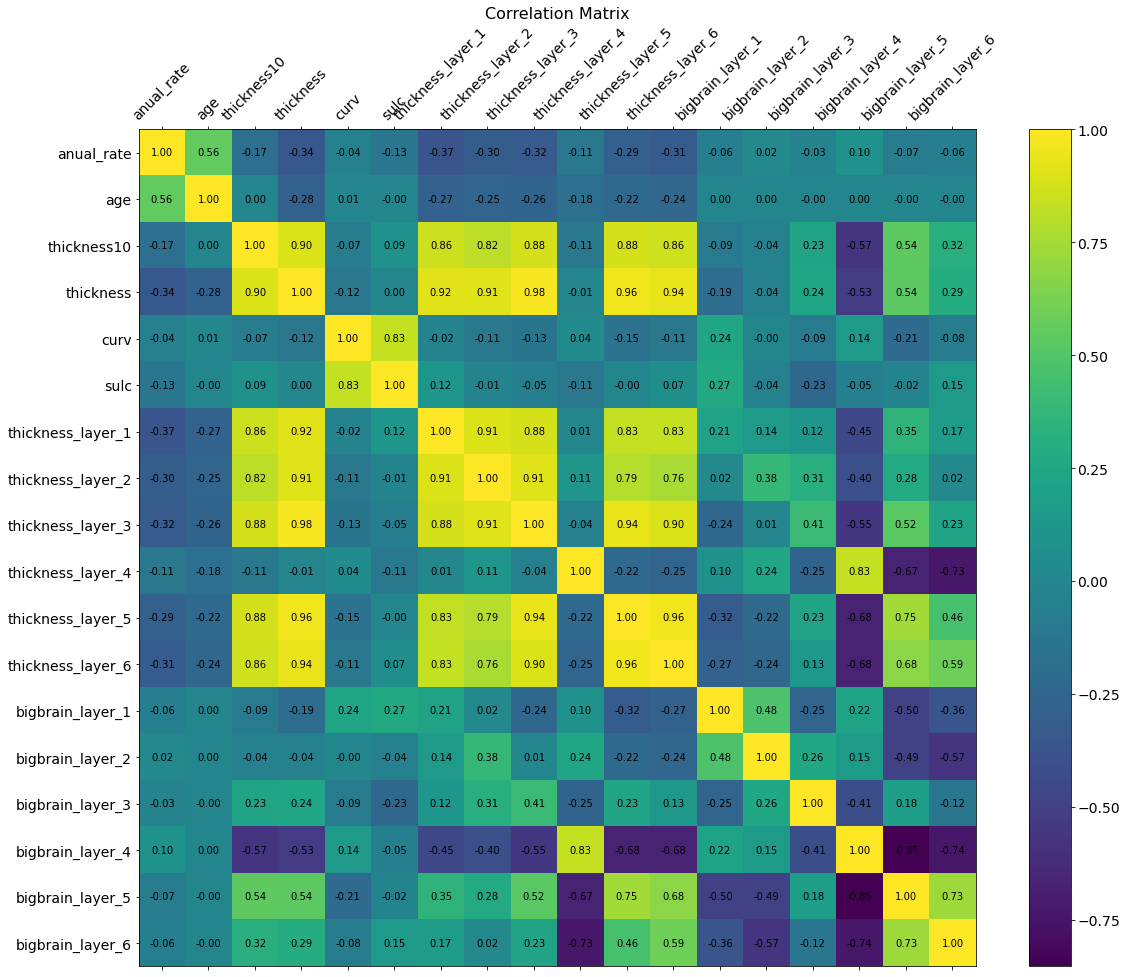

In [22]:
df2corr = df1[['anual_rate','age','thickness10','thickness','curv', 'sulc',
              'thickness_layer_1','thickness_layer_2','thickness_layer_3',
              'thickness_layer_4','thickness_layer_5','thickness_layer_6',
              'bigbrain_layer_1','bigbrain_layer_2','bigbrain_layer_3',
              'bigbrain_layer_4','bigbrain_layer_5','bigbrain_layer_6']]

f = plt.figure(figsize=(19, 15))
s = 14
data = df2corr.corr()
plt.matshow(data, fignum=f.number)
for (x, y), value in np.ndenumerate(data):
    plt.text(x, y, f"{value:.2f}", va="center", ha="center")
plt.xticks(range(df2corr.select_dtypes(['number']).shape[1]), df2corr.select_dtypes(['number']).columns, fontsize=s, rotation=45)
plt.yticks(range(df2corr.select_dtypes(['number']).shape[1]), df2corr.select_dtypes(['number']).columns, fontsize=s)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=s)
plt.title('Correlation Matrix', fontsize=16);

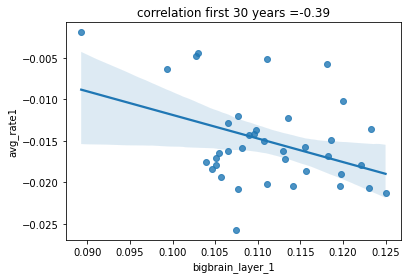

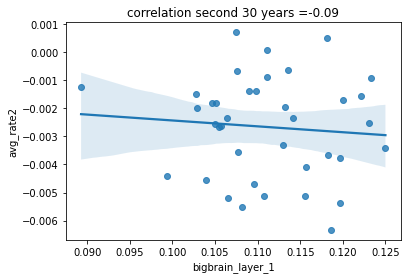

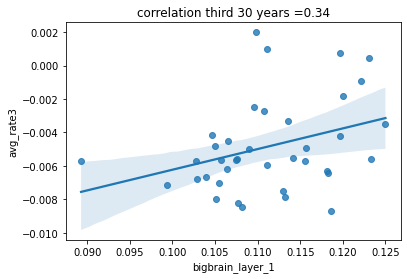

In [32]:
list_avg_rate = []

for i in df1.atlasEcono.unique():
    
    df5 = df1[df1.atlasEcono==i]
    avg_rate1 = df5[df1.age<=30].anual_rate.mean()
    avg_rate2 = df5[(df1.age<60) & (df1.age>30)].anual_rate.mean()
    avg_rate3 = df5[df1.age>=60].anual_rate.mean()
    
    l1 = df5.thickness_layer_1.mean()
    b1 = df5.bigbrain_layer_1.mean()
    t10 = df5.thickness10.mean()
    
    list_avg_rate.append([str(i),i,l1,b1,t10,avg_rate1,avg_rate2,avg_rate3])

df5 = pd.DataFrame(list_avg_rate)#.sort_values(by=2)
df5.columns = ['atlasEcono_str', 'atlasEcono_int',
               'thickness_layer_1', # resultados sofrem interferencia da espessura inicial
               'bigbrain_layer_1', 
               'thickness10', # resultados do trabalho do bruno
               'avg_rate1', 'avg_rate2', 'avg_rate3']

test = 'bigbrain_layer_1'

corr = np.corrcoef(df5[test],df5.avg_rate1)[0, 1]
sns.regplot(x=test,y='avg_rate1', data=df5).set(title="correlation first 30 years ="+ str(np.round(corr,2)))
plt.show()

corr = np.corrcoef(df5[test],df5.avg_rate2)[0, 1]
sns.regplot(x=test,y='avg_rate2', data=df5).set(title="correlation second 30 years ="+ str(np.round(corr,2)))
plt.show()

corr = np.corrcoef(df5[test],df5.avg_rate3)[0, 1]
sns.regplot(x=test,y='avg_rate3', data=df5).set(title="correlation third 30 years ="+ str(np.round(corr,2)))
plt.show()


In [11]:
features_sets = [#['age'],
                 #['age','macro_area'],
                 #['age','thickness10'],
                 #['age','thickness'],
                 #['age','curv'],
                 #['age','sulc'],
                 #['age','hemisphere'],
                 ['age','bigbrain_layer_1'],
                 #['age','bigbrain_layer_2'],
                 #['age','bigbrain_layer_3'],
                 #['age','bigbrain_layer_4'],
                 #['age','bigbrain_layer_5'],
                 #['age','bigbrain_layer_6'],
                 
                 ['age','thickness10','macro_area', 'sulc','hemisphere',
                  'bigbrain_layer_1','bigbrain_layer_2','bigbrain_layer_3',
                  'bigbrain_layer_4','bigbrain_layer_5','bigbrain_layer_6', 'atlasEcono'],
    
                 ['age','thickness10','macro_area', 'curv',
                  'thickness_layer_1','thickness_layer_2','thickness_layer_3',
                  'thickness_layer_4','thickness_layer_5',],

    
                 ['age','thickness10','macro_area','curv', 'sulc', 'hemisphere',
                  'thickness_layer_1','thickness_layer_2','thickness_layer_3',
                  'thickness_layer_4','thickness_layer_5','thickness_layer_6', 'atlasEcono'],
    
                 ['age','thickness10','macro_area','curv', 'sulc',
                  'thickness_layer_1','thickness_layer_2','thickness_layer_3',
                  'thickness_layer_4','thickness_layer_5'],
                 
                 ['age','thickness10','macro_area',
                  'bigbrain_layer_1','bigbrain_layer_2',
                  'bigbrain_layer_4','bigbrain_layer_5',],
    
                 ['age','thickness10','macro_area',
                  'bigbrain_layer_1','bigbrain_layer_2','bigbrain_layer_3',
                  'bigbrain_layer_4','bigbrain_layer_5','bigbrain_layer_6'],
    
                 ['age','curv',
                  'bigbrain_layer_1','bigbrain_layer_2','bigbrain_layer_3',
                  'bigbrain_layer_4','bigbrain_layer_5','bigbrain_layer_6'],
                 
                 ['age','thickness10','macro_area','thickness','curv',
                  'bigbrain_layer_1','bigbrain_layer_2','bigbrain_layer_3',
                  'bigbrain_layer_4','bigbrain_layer_5'],

                 ['age','thickness10','macro_area','thickness','sulc',
                  'bigbrain_layer_1','bigbrain_layer_2','bigbrain_layer_3',
                  'bigbrain_layer_4','bigbrain_layer_5', 'bigbrain_layer_6'],
                 
                 ['age','thickness10','macro_area','bigbrain_layer_1'],
                 ['age','thickness10','bigbrain_layer_1']
                ]

#### 2.4. Model Training and Testing

In [ ]:
inexplicable_strutures = {}
for key in pd.Series([x[1:] for x in df1.h_structure.unique()]).unique():
    inexplicable_strutures[key]=0
    
list_performance = []
testes = []
shap_info = []

for features in tqdm(features_sets):    

    X = df1[features]
    y = df1.anual_rate
    performance = []
    for struture in set([x[1:] for x in df1.h_structure.unique()]):

        # Train Test Split
        test_index = df1[(df1.h_structure=='1'+struture)|(df1.h_structure=='0'+struture)].index
        train_index = set(df1.index)-set(test_index)
        X_train = X.loc[train_index]
        X_test = X.loc[test_index]
        y_train = y.loc[train_index]
        y_test = y.loc[test_index]
        
        # Model Train
        lgbm = LGBMRegressor()
        lgbm.fit(X_train, y_train) #categorical_feature = [2]
        
        # Model Test
        y_pred = lgbm.predict(X_test)
        r2 = r2_score(y_test, y_pred)
        
        # SHAP
        explainer = shap.TreeExplainer(lgbm)
        shap_values_ = explainer.shap_values(X_train[features])
        pd.DataFrame(shap_values_).mad(axis=0)
        expected_value = explainer.expected_value
        
        # Save Performance
        performance.append([struture,r2]+list(pd.DataFrame(shap_values_).mad(axis=0)))
    
    # Save SHAP
    shap_info.append([[features], shap_values_, X_train, expected_value])
    
    # Ajust and save to List of all Performance
    performance = pd.DataFrame(performance).sort_values(by=1, ascending=False)
    performance.columns = ['struture','r2']+features
    performance['features'] = [features]*len(performance)
    list_performance.append(performance)
    
    # Handling Inexplicable strutures
    for key in performance[performance.r2<0.5].struture:
        inexplicable_strutures[key]=inexplicable_strutures[key]+1
    testes.append([features, performance.mean()[1], performance[performance.r2>0.5].mean()[1], len(performance[performance.r2<0.5])])
    
# Finishing
testes = pd.DataFrame(testes).rename(columns={0:'features',1:'r2_all',2:'r2_clean',3:'inexplicable_strutures'})

  0%|                                                    | 0/12 [00:00<?, ?it/s]

#### 2.4. Model Evaluation

In [ ]:
testes

In [ ]:
pd.DataFrame.from_dict(inexplicable_strutures, orient='index').sort_values(0, ascending=False)

## 3. Explicabilidade

In [ ]:
pd.concat(list_performance, axis=0).mean().sort_values()

In [ ]:
#boruta
#matriz de corr

-----------

In [ ]:
n=2
shap.summary_plot(shap_info[n][1], 
                  feature_names =shap_info[n][0][0],
                  plot_type='bar'
                 )

In [ ]:
# Referencia
plt.figure(figsize=(10,5))
plt.title('Variação na Espessura por idade')
for i in range(76):
    plt.scatter(taxa_anual.columns, taxa_anual.iloc[i], alpha=0.4, c=taxa_anual.columns, cmap=plt.cm.magma, s=20)
    plt.xlim(5,85)
    plt.ylim(-0.055,0.01)
plt.show()

In [ ]:
taxa_anual.index

In [ ]:
# handling inexplicables
inexplicables = list_performance[n][list_performance[n].r2<0.5].struture.to_list()
inexplicables_index = []
for i in inexplicables:
    inexplicables_index.extend(df1[(df1.h_structure=='1'+struture)|(df1.h_structure=='0'+struture)].index)

# axis X 
df4 = shap_info[n][2]
df4 = df4.drop(index=inexplicables_index, errors='ignore')

# axis Y
df3 = pd.DataFrame(shap_info[n][1] + shap_info[n][3]) # mudando baseline
df3.columns= shap_info[n][0]
df3.index = df4.index
df3 = df3.drop(index=inexplicables_index, errors='ignore')    
    
for f in shap_info[n][0][0]:
    
    # regressao polionomial
    z = np.polyfit(df4[f], [a[0] for a in df3[f].values], 3)
    p = np.poly1d(z)
    xp = np.linspace(df4[f].min(), df4[f].max(), 100)
    
    # referencia
    mean_mean_shap = df3.describe().mean(axis=1)[1]
    mean_std_shap = df3.describe().mean(axis=1)[2]
    init = mean_mean_shap + mean_std_shap/2
    final = mean_mean_shap - mean_std_shap/2
    
    # plot
    plt.figure(figsize=(10,5))
    plt.title(f)
    _ = plt.plot(xp, p(xp), '-',)
    plt.fill_between([df4[f].min(), df4[f].max()], init, final, alpha=.05)
    plt.scatter(df4[f], df3[f],c=df4.age, cmap=plt.cm.magma, s=20)
    plt.show()

In [ ]:
# handling inexplicables
inexplicables = list_performance[n][list_performance[n].r2<0.5].struture.to_list()
inexplicables_index = []
for i in inexplicables:
    inexplicables_index.extend(df1[(df1.h_structure=='1'+struture)|(df1.h_structure=='0'+struture)].index)

# axis X 
df4 = shap_info[n][2]
df4 = df4.drop(index=inexplicables_index, errors='ignore')

# axis Y
df3 = pd.DataFrame(shap_info[n][1] + shap_info[n][3]) # mudando baseline
df3.columns= shap_info[n][0]
df3.index = df4.index
df3 = df3.drop(index=inexplicables_index, errors='ignore')    
    
for f in shap_info[n][0][0]:
    
    # regressao polionomial
    z = np.polyfit(df4[f], [a[0] for a in df3[f].values], 3)
    p = np.poly1d(z)
    xp = np.linspace(df4[f].min(), df4[f].max(), 100)
    
    # referencia
    mean_mean_shap = df3.describe().mean(axis=1)[1]
    mean_std_shap = df3.describe().mean(axis=1)[2]
    init = mean_mean_shap + mean_std_shap/2
    final = mean_mean_shap - mean_std_shap/2
    
    # plot
    plt.figure(figsize=(10,5))
    plt.title(f)
    _ = plt.plot(xp, p(xp), '-',)
    plt.fill_between([df4[f].min(), df4[f].max()], init, final, alpha=.05)
    plt.scatter(df4[f], df3[f],c=df4.macro_area, cmap=plt.cm.viridis, s=20)
    plt.show()

In [ ]:
plot_tree(lgbm, figsize = (30,30), 
          show_info = ['split_gain','internal_value','internal_count','data_percentage','leaf_count',])         

-------------

## 4. ToDo

-------------

## 5. Old but important Code

#### 5.1. Criando anualrate.parquet

In [ ]:
# freesufer data
mri_subs_all = pp.read_parquet(mri_subs_path)
print('freesufer data')

# drop zeros and encode cats
mri_subs = pp.clean(mri_subs_all)
print('drop zeros and encode cats')

# quality assessment
bad_participants = pp.find_bad_ones(mri_areas_path)
mri_subs = pp.eliminate_bad_ones(bad_participants, mri_subs)
print('quality assessment')

# add identification features
mri_subs = pp.cat2int(mri_subs, cat_features=['sex', 'handedness', 'hemisphere'])
print('add identification features')

# add h_atlasDF
mri_subs['h_atlasDF'] = mri_subs.hemisphere.astype(str) + mri_subs.atlasDF.astype(str)
print('add h_atlasDF')

# add bigbrain features
mri_subs = pp.bb_features(bb_path, mri_subs)
print('add bigbrain')

# h_atlasDF to int
mri_subs['h_atlasDF'] = mri_subs['h_atlasDF'].replace('0-1', '-1')
mri_subs['h_atlasDF'] = mri_subs['h_atlasDF'].replace('1-1', '-1')
mri_subs.h_atlasDF = mri_subs.h_atlasDF.astype('int32')
mri_subs.h_atlasDF.unique()

# create dict_groupby 
dict_groupby = {}
keys = ['participant',  'age', 'sex', 'handedness',
        'hemisphere', 'atlasDF', 'area', 'curv','sulc', 'thickness', #'h_atlasDF', 
        'bigbrain_layer_1','bigbrain_layer_2','bigbrain_layer_3','bigbrain_layer_4','bigbrain_layer_5','bigbrain_layer_6']

for key in keys:
    dict_groupby[key] = []
dict_groupby['h_atlasDF'] = []
print('create dict_groupby')

for i, participant in enumerate(mri_subs.participant.unique()):
    
    df = mri_subs[mri_subs.participant == participant].groupby(['h_atlasDF']).mean()
    df['participant_i'] = i
    df['participant'] = participant
    print(i)
    
    for key in keys:
        dict_groupby[key].extend(df[key])
    dict_groupby['h_atlasDF'].extend(df.index)

df0 = pd.DataFrame(dict_groupby)

df0.to_parquet("/home/brunovieira/Tamires_Experiments/Bases_de_Dados/MRI_2_anualrate_894_v2.parquet")
df0.head()

#### 5.2. Criando Age_Stable.csv

In [ ]:
#derivada = taxa_anual.idxmax(axis=1)
#derivada = derivada.reset_index()
#derivada['hemisferio'] = [a[0] for a in derivada['atlasEcono']]
#derivada['atlasEcono'] = [a[1:] for a in derivada['atlasEcono']]
#derivada['bigest_slope'] = np.array(taxa_anual.min(axis=1))
#derivada = derivada.rename(columns={'atlasEcono':'econo',0:'age_stable'})
#derivada.to_csv('/home/brunovieira/Tamires_Experiments/Bases_de_Dados/Age_Stable.csv')

5.3 Rascunho

In [ ]:
# Referencia
plt.figure(figsize=(10,5))
plt.title('Variação na Espessura por idade')
for i in range(76):
    plt.scatter(taxa_anual.index, taxa_anual.iloc[i], alpha=0.4, c=taxa_anual.index, cmap=plt.cm.viridis, s=20)
    plt.xlim(5,85)
    plt.ylim(-0.055,0.01)
plt.show()